Topic Modelling & ScatterText Analysis - Matthew Jarrams

In this notebook, I develop cleaning cells to create a series of tokenzied reviews to explore for topic modelling and SpaCy library ScatterText

In [1]:
import json
import pandas as pd
from num2words import num2words
import contractions
import nltk
import spacy

Read in CSV of reviews

In [3]:
alberta = pd.read_csv('albertaRestrauntReviews.csv')
alberta_explode = alberta.assign(categories = alberta.categories.str.split(', ')).explode('categories')
albertaClean = alberta[['business_id', 'name', 'address', 'stars', 'is_open', 'review_count', 'attributes', 'categories', 'review_stars', 'text', 'date']]
albertaClean

,business_id,name,address,stars,is_open,review_count,attributes,categories,review_stars,text,date
0,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",3,So much to like about this place--the beautifu...,2012-11-06 23:35:15
1,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,I'm not a coffee connoisseur so I'm not review...,2013-05-28 23:16:30
2,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,"I really loved it here, makes me wish I lived ...",2013-09-04 19:49:33
3,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",2,The kids who work at Roast are friendly. They...,2013-07-14 21:38:06
4,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,"With a Toast to Roast, I say welcome to the E-...",2012-09-11 23:54:24
...,...,...,...,...,...,...,...,...,...,...,...
68877,hn9Toz3s-Ei3uZPt7esExA,West Side Kebab House,2470 Guardian Road NW,4.5,0,18,"{'Ambience': ""{'touristy': False, 'hipster': F...","Middle Eastern, Restaurants",5,YES.\n\nI have been to 2 other comparable Midd...,2017-03-13 19:47:08
68878,hn9Toz3s-Ei3uZPt7esExA,West Side Kebab House,2470 Guardian Road NW,4.5,0,18,"{'Ambience': ""{'touristy': False, 'hipster': F...","Middle Eastern, Restaurants",5,We had the beef plate medium rare that was mou...,2018-04-14 23:41:03
68879,hn9Toz3s-Ei3uZPt7esExA,West Side Kebab House,2470 Guardian Road NW,4.5,0,18,"{'Ambience': ""{'touristy': False, 'hipster': F...","Middle Eastern, Restaurants",5,Excellent Mediterranean food! Always cooked to...,2018-06-19 02:02:41
68880,hn9Toz3s-Ei3uZPt7esExA,West Side Kebab House,2470 Guardian Road NW,4.5,0,18,"{'Ambience': ""{'touristy': False, 'hipster': F...","Middle Eastern, Restaurants",4,This was my first visit to West Side Kebab Hou...,2017-03-24 01:46:31


Create a dataframe of all businesses (reviews stored as a list of lists)

In [12]:
businessReview = alberta.groupby(by="business_id").aggregate({'name' : 'first',
                                                              'text' : lambda x: (list(x)),
                                                        'review_count' : 'first',
                                                        'categories' :'first'}).reset_index()

print("Dataframe with the restruant and the reviews all grouped into a list of lists with the number of reviews incldued as well.")
businessReview[['name', 'text', 'review_count', 'categories']].sort_values(by='review_count', ascending=False)

Dataframe with the restruant and the reviews all grouped into a list of lists with the number of reviews incldued as well.


,name,text,review_count,categories
584,Duchess Bake Shop,"[I love, love the baked goods in this bakery. ...",486,"Patisserie/Cake Shop, Food, Restaurants, Baker..."
1635,SugarBowl,[Met a friend for breakfast and we shared the ...,435,"Juice Bars & Smoothies, American (New), Cafes,..."
1792,Tres Carnales Taqueria,[Quite good tacos - standard tacqueria - these...,429,"Restaurants, Mexican"
2030,Meat,"[Wowza, the BEST mac and cheese I've had in my...",420,"Southern, Barbeque, Restaurants, Breakfast & B..."
1735,Padmanadi Vegetarian Restaurant,[I'm so glad my friend introduced me to this p...,271,"Restaurants, Vegan, Indonesian, Vegetarian"
...,...,...,...,...
1949,Joe's Famous Donair & Burger Ltd,[Visited Joe's Famous Donair 2 times this past...,5,"Burgers, Restaurants, Fast Food"
637,Saigon Delights,[We came in and ordered. The waiter waits unti...,5,"Vietnamese, Restaurants"
650,Garage Burger Bar & Grill,[The walls of this downtown burger joint are p...,5,"Nightlife, Restaurants, Burgers, Bars"
657,Fine Pizza and Donair,[Craving late-night munchies? This place has g...,5,"Pizza, Restaurants, Food, Burgers, Halal, Donairs"


In [13]:
businessReviewCopy = businessReview.copy(deep=True)


In [14]:
len(albertaClean)

68882

In [15]:
allReviewsList = list(businessReview["text"])

In [16]:
print("tokenize the first pizza resturants reviews")
for i in range(len(allReviewsList)):
    for j in range(len(allReviewsList[i])):
        # print(i, j)
        review = allReviewsList[i][j].split(" ")
        allReviewsList[i][j] = review

tokenize the first pizza resturants reviews


In [17]:
allReviewsList[0][0]

['This',
 'place',
 'is',
 'disgusting,',
 'and',
 'proof',
 'that',
 'Edmonton',
 'is',
 'not',
 'a',
 'foodie',
 'city',
 'if',
 'a',
 'business',
 'like',
 'this',
 'can',
 'stay',
 'open.',
 'We',
 'were',
 'at',
 'the',
 'Royal',
 'Alexandra',
 'hospital,',
 'and',
 'wanted',
 'diner',
 'food.',
 'It',
 'was',
 'so',
 'disgusting,',
 'even',
 'though',
 'I',
 'was',
 'hungry,',
 'I',
 "couldn't",
 'finish',
 'it.',
 'The',
 'service',
 'was',
 'fine',
 'though',
 'I',
 "don't",
 'go',
 'to',
 'a',
 'restaurant',
 'for',
 'the',
 'service,',
 'but',
 'the',
 'taste',
 'of',
 'the',
 'food.\n\nI',
 'ordered',
 'the',
 'Huevos',
 'Racheros.',
 'The',
 'tortilla',
 'came',
 'out',
 'deep',
 'fried',
 '(the',
 'first',
 'for',
 'me),',
 'and',
 'the',
 'hashbrowns',
 'were',
 'all',
 'deep',
 'fried.',
 'There',
 'were',
 'plastic',
 'tubs',
 'for',
 'my',
 'sour',
 'cream',
 'and',
 'salsa,',
 'and',
 'the',
 'meal',
 'was',
 'so',
 'greasy',
 'that',
 'afterwards',
 'we',
 'all',
 'f

In [18]:
tok = list(businessReviewCopy['text'])

In [19]:
newList = []
for i in tok:
    restList = []
    for j in i:
        str1 = ' '.join([str(elem) for elem in j])
        # print(str1)
        restList.append(str1)
    newList.append(restList)

In [20]:
businessReview['rawData'] = newList

In [21]:
businessReview

,business_id,name,text,review_count,categories,rawData
0,--7PUidqRWpRSpXebiyxTg,Humpty's Family Restaurant,"[[This, place, is, disgusting,, and, proof, th...",12,"Breakfast & Brunch, Restaurants","[This place is disgusting, and proof that Edmo..."
1,-2oyyfOSHs1UElr3Dc1aKQ,Highlands Kitchen,"[[The, best, unique, dinner, made, with, the, ...",12,"Ukrainian, Restaurants, Canadian (New), Comfor...",[The best unique dinner made with the freshest...
2,-3GD07waps96fB_okEwFqw,Brits Fish & Chips,"[[Really, good, fish, and, chips., \n\nBest, t...",34,"Restaurants, British",[Really good fish and chips. \n\nBest this sid...
3,-4lNMmoW7gRxkH0c2dfXfA,Ripe Tomato,"[[this, pizza, was, so, bomb., Remind, me, of,...",5,"Pizza, Restaurants",[this pizza was so bomb. Remind me of firecrus...
4,-4qgeqxb2hKe3dUUH__j8Q,T&T Supermarket,"[[Cool., This, place, is, located, inside, Wes...",48,"Ethnic Food, Imported Food, International Groc...",[Cool. This place is located inside West Edmon...
...,...,...,...,...,...,...
2405,zpXKeyg8GD2Z27Biaeqo8A,A&W,"[[A&W, are, known, mainly, as, being, a, highe...",6,"Burgers, Restaurants, Fast Food, Breakfast & B...",[A&W are known mainly as being a higher class ...
2406,zun3rAOoiAyeIL3JIB4eYg,Browns Socialhouse Manning,"[[Small, portions, on, an, oversized, price., ...",27,"Pubs, Burgers, American (Traditional), Pizza, ...",[Small portions on an oversized price. I'm no...
2407,zx7XemDyT296vmKnFtZSyQ,Tiffin India's Fresh Kitchen,"[[My, first, visit., Overall, a, good, experie...",15,"Indian, Fast Food, Restaurants",[My first visit. Overall a good experience... ...
2408,zxJfzu6Hy4E5bjP9fzh93g,Nikki's,"[[I, have, eaten, here, a, couple, times., The...",8,"Fast Food, Restaurants, Burgers",[I have eaten here a couple times. The burgers...


Cleaning cell to remove all special characters from reviews

In [22]:
from num2words import num2words
import contractions

reviewList = businessReview['rawData']

cleanText = []
j =0
for bus in reviewList:
    busCleanReviews = []
    for i in bus:
        # print(i)
        noPunc = i.lower().replace(".","").replace("'s", "s")
        noPunc = noPunc.replace(",", "").replace("\n", " ")
        noPunc = noPunc.replace("(", "").replace(")", "").replace("  ", " ").replace("!", "").replace("&", "").replace(":", "").replace("?", "").replace("-", "")
        noPunc = noPunc.replace('"', "")
        noPunc = noPunc.replace('*', "")
        expanded_words = []   
        for word in noPunc.split():
        # using contractions.fix to expand the shortened words
            expanded_words.append(contractions.fix(word))  
        
        expanded_text = ' '.join(expanded_words)
        busCleanReviews.append(expanded_text)
    cleanText.append(busCleanReviews)

Example of a cleaned review

In [298]:
reviewList[1614][11]

'Service was extremely quick and service was friendly. The quality of the sushi was fresh and the rice was not old. Despite the appearance of uneven cutting and presentation, the taste was quite flavourful. Price was very reasonable and the perfect place to grab a quick lunch within the food court. I will definitely return when I have a hankering for quick sushi, definitely satisfied the cravings!'

In [299]:
cleanText[1614][11]

'service was extremely quick and service was friendly the quality of the sushi was fresh and the rice was not old despite the appearance of uneven cutting and presentation the taste was quite flavourful price was very reasonable and the perfect place to grab a quick lunch within the food court i will definitely return when i have a hankering for quick sushi definitely satisfied the cravings'

Tokenize the reviews

In [23]:
##From Class ##
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

cleanTokens = []
for bus in cleanText:
    busCleanTokens = []
    for i in bus:
        busCleanTokens.append(word_tokenize(i))
    
    cleanTokens.append(busCleanTokens)

Run checks on tokens to ensure clean

In [24]:
for i in cleanTokens:
    for j in i:
        l = 0
        for k in j:
            j[l] = k.replace("+", "")
            l+=1
            if(k == "$" or k.isdigit()):
                j.remove(k)

In [25]:
businessReview["cleanedTokens"] = cleanTokens

Cell to clean individual reviews

In [26]:
reviewSeperate = list(albertaClean['text'])

cleanTextSeperate = []
j =0
for i in reviewSeperate:
    # seperateCleanReviews = []
    # for i in bus:
        # print(i)
    noPunc = i.lower().replace(".","").replace("'s", "s").replace("$", "")
    noPunc = noPunc.replace(",", "").replace("\n", " ")
    noPunc = noPunc.replace("(", "").replace(")", "").replace("  ", " ").replace("!", "").replace("&", "").replace(":", "").replace("?", "").replace("-", " ")
    noPunc = noPunc.replace("\'".replace(" ", ""), "")
    noPunc = noPunc.replace('"', "")
    noPunc = noPunc.replace("/", "").replace("%", "").replace("~", "").replace(":", "").replace(";", "").replace("...", "")
    noPunc = noPunc.replace("`", "").replace("@", "").replace("=", "").replace("=", "").replace("+", "").replace(";", "").replace("#", "").replace("[", "")
    noPunc = noPunc.replace("]", "").replace("^", "").replace("¢", "").replace("_", "").replace("'", "")
    noPunc = noPunc.replace("|", "").replace("{", "").replace("}", "").replace("！", "").replace("？", "").replace("", "").replace("'", "").replace("，", "")
    result = ''.join([i for i in noPunc if not i.isdigit()]).replace("  ", " ")
    result = result.replace('*', "")
    # if(result != ""):
    expanded_words = []   
    for word in result.split():
    # using contractions.fix to expand the shortened words
        expanded_words.append(contractions.fix(word))  
    
    expanded_text = ' '.join(expanded_words)
    cleanTextSeperate.append(expanded_text)

In [27]:
cleanTextSeperate[20]

'i am always finding new ways to get in the way of a regular sleeping schedule so it does not surprise me that most of the time i head to roast i am scooted out not long after because they are closing the atmosphere is part local and rustic feeling and the other part is a jay z and kanye west collaborative album cover flash shine and wood the tank of water for all customers is a nice touch especially when they chop some cucumber in there the coffee and tea menu is pretty plain and basic but the baristas know what they are doing and made sure i got my custom gibraltar parts espresso parts steamed milk the way i want it the most pleasant surprise was the wine and beer selection i usually spy into the beer fridge and am forced make a difficult decision with a kind of beer or even getting one at all roast is a great place whether you are there to relax or have an awkward first date'

Tokenize cleaned text

In [28]:
##From Class ##
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

cleanTokensSeperate = []
for bus in cleanTextSeperate:
    cleanTokensSeperate.append(word_tokenize(bus))

In [29]:
albertaClean["cleanTokens"] = cleanTokensSeperate

C:\Users\User\AppData\Local\Temp\ipykernel_19488\3390862322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean["cleanTokens"] = cleanTokensSeperate


Create average rating scores for each  business

In [30]:
businessStars = albertaClean.groupby(by="business_id").aggregate({'review_stars' : lambda x: list(x)})
businessStars

,review_stars
business_id,
--7PUidqRWpRSpXebiyxTg,"[1, 2, 3, 1, 1, 1, 2, 4, 3, 1, 1, 1]"
-2oyyfOSHs1UElr3Dc1aKQ,"[5, 4, 5, 4, 3, 3, 4, 4, 4, 4, 5, 4]"
-3GD07waps96fB_okEwFqw,"[4, 4, 5, 5, 1, 2, 5, 4, 4, 5, 3, 1, 4, 3, 5, ..."
-4lNMmoW7gRxkH0c2dfXfA,"[5, 1, 5, 5, 5]"
-4qgeqxb2hKe3dUUH__j8Q,"[4, 3, 4, 3, 5, 5, 4, 4, 3, 4, 5, 4, 4, 4, 5, ..."
...,...
zpXKeyg8GD2Z27Biaeqo8A,"[2, 4, 3, 1, 1, 1, 1]"
zun3rAOoiAyeIL3JIB4eYg,"[2, 3, 5, 4, 1, 5, 3, 5, 1, 4, 5, 4, 4, 5, 1, ..."
zx7XemDyT296vmKnFtZSyQ,"[3, 5, 4, 4, 5, 4, 5, 5, 5, 4, 4, 4, 4, 5, 5]"


Merge business reviews with star ratings

In [31]:
finalDf = pd.merge(businessReview, businessStars, on="business_id")

In [32]:
finalDf

,business_id,name,text,review_count,categories,rawData,cleanedTokens,review_stars
0,--7PUidqRWpRSpXebiyxTg,Humpty's Family Restaurant,"[[This, place, is, disgusting,, and, proof, th...",12,"Breakfast & Brunch, Restaurants","[This place is disgusting, and proof that Edmo...","[[this, place, is, disgusting, and, proof, tha...","[1, 2, 3, 1, 1, 1, 2, 4, 3, 1, 1, 1]"
1,-2oyyfOSHs1UElr3Dc1aKQ,Highlands Kitchen,"[[The, best, unique, dinner, made, with, the, ...",12,"Ukrainian, Restaurants, Canadian (New), Comfor...",[The best unique dinner made with the freshest...,"[[the, best, unique, dinner, made, with, the, ...","[5, 4, 5, 4, 3, 3, 4, 4, 4, 4, 5, 4]"
2,-3GD07waps96fB_okEwFqw,Brits Fish & Chips,"[[Really, good, fish, and, chips., \n\nBest, t...",34,"Restaurants, British",[Really good fish and chips. \n\nBest this sid...,"[[really, good, fish, and, chips, best, this, ...","[4, 4, 5, 5, 1, 2, 5, 4, 4, 5, 3, 1, 4, 3, 5, ..."
3,-4lNMmoW7gRxkH0c2dfXfA,Ripe Tomato,"[[this, pizza, was, so, bomb., Remind, me, of,...",5,"Pizza, Restaurants",[this pizza was so bomb. Remind me of firecrus...,"[[this, pizza, was, so, bomb, remind, me, of, ...","[5, 1, 5, 5, 5]"
4,-4qgeqxb2hKe3dUUH__j8Q,T&T Supermarket,"[[Cool., This, place, is, located, inside, Wes...",48,"Ethnic Food, Imported Food, International Groc...",[Cool. This place is located inside West Edmon...,"[[cool, this, place, is, located, inside, west...","[4, 3, 4, 3, 5, 5, 4, 4, 3, 4, 5, 4, 4, 4, 5, ..."
...,...,...,...,...,...,...,...,...
2405,zpXKeyg8GD2Z27Biaeqo8A,A&W,"[[A&W, are, known, mainly, as, being, a, highe...",6,"Burgers, Restaurants, Fast Food, Breakfast & B...",[A&W are known mainly as being a higher class ...,"[[aw, are, known, mainly, as, being, a, higher...","[2, 4, 3, 1, 1, 1, 1]"
2406,zun3rAOoiAyeIL3JIB4eYg,Browns Socialhouse Manning,"[[Small, portions, on, an, oversized, price., ...",27,"Pubs, Burgers, American (Traditional), Pizza, ...",[Small portions on an oversized price. I'm no...,"[[small, portions, on, an, oversized, price, i...","[2, 3, 5, 4, 1, 5, 3, 5, 1, 4, 5, 4, 4, 5, 1, ..."
2407,zx7XemDyT296vmKnFtZSyQ,Tiffin India's Fresh Kitchen,"[[My, first, visit., Overall, a, good, experie...",15,"Indian, Fast Food, Restaurants",[My first visit. Overall a good experience... ...,"[[my, first, visit, overall, a, good, experien...","[3, 5, 4, 4, 5, 4, 5, 5, 5, 4, 4, 4, 4, 5, 5]"
2408,zxJfzu6Hy4E5bjP9fzh93g,Nikki's,"[[I, have, eaten, here, a, couple, times., The...",8,"Fast Food, Restaurants, Burgers",[I have eaten here a couple times. The burgers...,"[[i, have, eaten, here, a, couple, times, the,...","[4, 5, 4, 4, 4, 3, 5, 4]"


In [33]:
avgRat = []
for i in list(finalDf['review_stars']):
    totalStars = 0
    for j in i:
        totalStars+= j
    avgStars = totalStars / len(i)
    avgRat.append(avgStars)

finalDf['avgRating'] = avgRat

Series of fucntions to create ngrams of any text

Function adapted from:


Albert Au Yeung. Generating n-grams from sentences in python: Albert Au Yeung. Retrieved March 18, 2023 from https://albertauyeung.github.io/2018/06/03/generating-ngrams.html/ 

In [34]:
from collections import Counter
import matplotlib.pyplot as plt
import wordcloud

plt.rcParams["figure.figsize"] = [16, 9]


def create_ngrams(token_list, nb_elements):
    """
    Create n-grams for list of tokens
    Parameters
    ----------
    token_list : list
        list of strings
    nb_elements :
        number of elements in the n-gram
    Returns
    -------
    Generator
        generator of all n-grams
    """
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    return (" ".join(ngram) for ngram in ngrams)



def create_ngramsList(token_list, nb_elements):
    """
    Create n-grams for list of tokens
    Parameters
    ----------
    token_list : list
        list of strings
    nb_elements :
        number of elements in the n-gram
    Returns
    -------
    Generator
        generator of all n-grams
    """
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    ngramList = []
    for i in ngrams:
        ngramList.append(" ".join(i))
        
    return ngramList

def frequent_words(list_words, ngrams_number=1, number_top_words=10):
    """
    Create n-grams for list of tokens
    Parameters
    ----------
    ngrams_number : int
    number_top_words : int
        output dataframe length
    Returns
    -------
    DataFrame
        Dataframe with the entities and their frequencies.
    """
    frequent = []
    if ngrams_number == 1:
        pass
    elif ngrams_number >= 2:
        list_words = create_ngrams(list_words, ngrams_number)
    else:
        raise ValueError("number of n-grams should be >= 1")
    counter = Counter(list_words)
    frequent = counter.most_common(number_top_words)
    return frequent


def make_word_cloud(text_or_counter, stop_words=None):
    if isinstance(text_or_counter, str):
        word_cloud = wordcloud.WordCloud(stopwords=stop_words).generate(text_or_counter)
    else:
        if stop_words is not None:
            text_or_counter = Counter(word for word in text_or_counter if word not in stop_words)
        word_cloud = wordcloud.WordCloud(stopwords=stop_words).generate_from_frequencies(text_or_counter)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

All cleaning done now

finalDf for restraunts grouped
albertaCleaned for all reviews

In [35]:
finalDf

,business_id,name,text,review_count,categories,rawData,cleanedTokens,review_stars,avgRating
0,--7PUidqRWpRSpXebiyxTg,Humpty's Family Restaurant,"[[This, place, is, disgusting,, and, proof, th...",12,"Breakfast & Brunch, Restaurants","[This place is disgusting, and proof that Edmo...","[[this, place, is, disgusting, and, proof, tha...","[1, 2, 3, 1, 1, 1, 2, 4, 3, 1, 1, 1]",1.750000
1,-2oyyfOSHs1UElr3Dc1aKQ,Highlands Kitchen,"[[The, best, unique, dinner, made, with, the, ...",12,"Ukrainian, Restaurants, Canadian (New), Comfor...",[The best unique dinner made with the freshest...,"[[the, best, unique, dinner, made, with, the, ...","[5, 4, 5, 4, 3, 3, 4, 4, 4, 4, 5, 4]",4.083333
2,-3GD07waps96fB_okEwFqw,Brits Fish & Chips,"[[Really, good, fish, and, chips., \n\nBest, t...",34,"Restaurants, British",[Really good fish and chips. \n\nBest this sid...,"[[really, good, fish, and, chips, best, this, ...","[4, 4, 5, 5, 1, 2, 5, 4, 4, 5, 3, 1, 4, 3, 5, ...",3.621622
3,-4lNMmoW7gRxkH0c2dfXfA,Ripe Tomato,"[[this, pizza, was, so, bomb., Remind, me, of,...",5,"Pizza, Restaurants",[this pizza was so bomb. Remind me of firecrus...,"[[this, pizza, was, so, bomb, remind, me, of, ...","[5, 1, 5, 5, 5]",4.200000
4,-4qgeqxb2hKe3dUUH__j8Q,T&T Supermarket,"[[Cool., This, place, is, located, inside, Wes...",48,"Ethnic Food, Imported Food, International Groc...",[Cool. This place is located inside West Edmon...,"[[cool, this, place, is, located, inside, west...","[4, 3, 4, 3, 5, 5, 4, 4, 3, 4, 5, 4, 4, 4, 5, ...",3.788462
...,...,...,...,...,...,...,...,...,...
2405,zpXKeyg8GD2Z27Biaeqo8A,A&W,"[[A&W, are, known, mainly, as, being, a, highe...",6,"Burgers, Restaurants, Fast Food, Breakfast & B...",[A&W are known mainly as being a higher class ...,"[[aw, are, known, mainly, as, being, a, higher...","[2, 4, 3, 1, 1, 1, 1]",1.857143
2406,zun3rAOoiAyeIL3JIB4eYg,Browns Socialhouse Manning,"[[Small, portions, on, an, oversized, price., ...",27,"Pubs, Burgers, American (Traditional), Pizza, ...",[Small portions on an oversized price. I'm no...,"[[small, portions, on, an, oversized, price, i...","[2, 3, 5, 4, 1, 5, 3, 5, 1, 4, 5, 4, 4, 5, 1, ...",3.571429
2407,zx7XemDyT296vmKnFtZSyQ,Tiffin India's Fresh Kitchen,"[[My, first, visit., Overall, a, good, experie...",15,"Indian, Fast Food, Restaurants",[My first visit. Overall a good experience... ...,"[[my, first, visit, overall, a, good, experien...","[3, 5, 4, 4, 5, 4, 5, 5, 5, 4, 4, 4, 4, 5, 5]",4.400000
2408,zxJfzu6Hy4E5bjP9fzh93g,Nikki's,"[[I, have, eaten, here, a, couple, times., The...",8,"Fast Food, Restaurants, Burgers",[I have eaten here a couple times. The burgers...,"[[i, have, eaten, here, a, couple, times, the,...","[4, 5, 4, 4, 4, 3, 5, 4]",4.125000


Final checks on cleaned tokens to ensure all cleaning was successful

In [36]:
checkList = list(albertaClean['cleanTokens'])
checkList2 = list(finalDf['cleanedTokens'])

In [37]:
count = 0
newList = []
index = 0
for i in checkList:
    revList = []
    for j in i:
        if(j.isalpha() == False):
            count+=1
            # print(j, index)
            j = j.strip()
            newJ = j.replace("/", "").replace("%", "").replace("'", " ").replace("~", "").replace(":", "").replace(";", "").replace(" ", "").replace("...", "")
            newJ = newJ.replace("`", "").replace("@", "").replace("=", "").replace("=", "").replace("+", "").replace(";", "").replace("#", "").replace("[", "")
            newJ = newJ.replace("]", "").replace(",", "").replace("^", "").replace("′", "").replace("¢", "").replace("_", "").replace("'", "").replace("，", "")
            newJ = newJ.replace("|", "").replace("{", "").replace("}", "").replace("！", "").replace("？", "").replace("", "").replace("'", "").replace("，", "")
            newJ = newJ.strip()
            if(len(newJ) != 0):
                revList.append(newJ)
        else:
            revList.append(j)
    newList.append(revList)
    index+=1
print(count)

168


Count occurences of non alpha characters

In [38]:
count = 0
index = 0
finalList2 = []
for i in newList:
    revFinal = []
    for j in i:
        if(j.isalpha() == False):
            count+=1
            print(j)
        else:
            revFinal.append(j)
    finalList2.append(revFinal)
print(count)

edmonton​
お店の中はとっても落ち着いててリラックス出来るし、何と言っても、、、
\
煎饼果子加酥脆鸡蛋灌饼加午餐肉羊肉串羊腰子。水煎包金针菇超辣。肉筋也比较辣面筋是提前腌过的。很正好吃
⁣
⁣
owner⁣
owner⁣
​​spring
us‍
‍
resturant。this
\for
feeling​
definitely​
unique​
restaurant​
thin​
many​
different​
pepperoni​
homemade​
original​
does​
recommend​
something​​g
accommodate​
dinner​
japanese​
‍
its​
char​
‍
\
going​
アジアテイストのカフェなので店員さんもお客さんもアジア人が多かったです。
とても親切な対応をしていただきました。
メニューも豊富で決めるのにとても時間がかかってしまいましたが、結局抹茶暑い夏には特にぴったりのカフェだと思います。
aveなので、バスでも行きやすく最高
pot涮涮鍋店位於亞省愛民頓市的唐人街經營至今已跨越七個年頭了。開業之初餐館只做晚市任食火鍋營業時間至凌晨是區內知名宵夜夜店。近年食肆延長營業時間除了提供全日任點任食火鍋外更加設午市及宵夜自選個人火鍋套餐劃一價錢一人一鍋包括免費湯底
種食材任選款及自助醬料吧非常適合單身人士或一大班朋友齊齊享用。
我個人特別喜歡一人一鍋形式的打邊爐除了較大家圍著同一個爐的傳統火鍋更衛生外更可按個人喜好選擇不同湯底和配料。其實火鍋湯底有人愛辣亦有人怕辣火鍋料方面更各有喜惡愛肉愛素彼此不同其中羊肉更非人人能夠接受所以一人一鍋確實是個偉大發明啊這家店為配合這個理念店內餐桌每個座位都裝設獨立調節熱量的內藏爐頭安放配合個人大小的湯鍋。同時派發每人一張表格按個人喜好勾出自選湯底及火鍋料交服務員下單再到自助醬料吧調配個人專用口味的醮醬完全不受他人的影響
than​
\mr
‍
‍
‍
​
​
⁣
⁣
⁣
left）
¾
¼
無意間路過看見試營運就試試蠻多服務生也都很親切很乾淨很明亮東西好吃種類也多。可是覺得有點小貴不過如果之後品質不變一樣會再光顧xd
‍
⁄
°
\lovers
​​denne
牛肉河粉的牛肉肉質鮮嫩配上生豆苗、九層塔與檸檬提味湯頭很美味。蝦仁炒時蔬有花椰菜四季豆蘑菇紅

If this cell's value is zero, reviews are clean!

In [39]:
count = 0
index = 0
for i in finalList2:
    for j in i:
        if(j.isalpha() == False):
            count+=1
            print(j)
print(count)

0


In [40]:
count = 0
newList = []
index = 0
for i in checkList2:
    revList = []
    for j in i:
        rev2List = []
        for k in j:
            if(k.isalpha() == False):
                count+=1
                # print(j, index)
                k = k.strip()
                newJ = k.replace("/", "").replace("%", "").replace("'", " ").replace("~", "").replace(":", "").replace(";", "").replace(" ", "").replace("...", "")
                newJ = newJ.replace("`", "").replace("@", "").replace("=", "").replace("=", "").replace("+", "").replace(";", "").replace("#", "").replace("[", "")
                newJ = newJ.replace("]", "").replace(",", "").replace("^", "").replace("′", "").replace("¢", "").replace("_", "").replace("'", "").replace("，", "")
                newJ = newJ.replace("|", "").replace("{", "").replace("}", "").replace("！", "").replace("？", "").replace("", "").replace("'", "").replace("，", "")
                newJ = newJ.strip()
                if(len(newJ) != 0):
                    rev2List.append(newJ)
            else:
                rev2List.append(k)
        revList.append(rev2List)
    newList.append(revList)
    index+=1
print(count)

53462


In [41]:
count = 0
index = 0
finalList = []
for i in newList:
    revList = []
    for j in i:
        rev2List = []
        for k in j:
            if(k.isalpha() == False):
                count+=1
                print(k)
            else:
                rev2List.append(k)
        revList.append(rev2List)
    finalList.append(revList)

print(count)

9am
14
34
12
3
4245
1414
12
20
2pc
2200
16
40
27
10min
‍
1pc
20
2020
1st
9am
10
5pm
699
30
4
6
7eleven
2nd
7lb
5mins
30
2020
97th
c2
80s
5
8
8
30
15
2
200
3000
1000
2500
350
20
20
7am9pm
15
500g
24
340g
9pm
1360
124st
598
2
2ndcups
350
375
350
495
495
7am9pm
20
15
352
20
30
5
45
55
455
45
35
8
1010
170
900pm
30
30
165
60th
60th
4
330am
5
3rd
15
1010
7oz
5
2nd
16
10
9
14oz
14oz
180
12
23ave
$
$
10pm
913
iwanttostudyon4thfloorcameronlibraryattheu
10
1090
3035ish
3
7
1
10
1
12
12
2015
850
three10
three10
20
2piece
5
60
366
124th
32
$
$
$
$
6pm
10
16
6
17th
10
15
$
25
124st
107ave
10
900
18th
1050
600
750
7
10
1015am
34
12
2314
$
2019
169
10
15
13
21
45
230pm
1795
150
075
34th
1199
50ea
1ea
chicken999
15
1699
110can
700lb
34th
2pm
14
15
6
$
3x
b5
109st
112st
8pm
8pm
715pm
400
a2
700
1500
b7
1300
b8
1300
990
1650
6pm
43
12
1pm
825
450
3
2500
3pm
9am
50
40ish
15
6
6
2014
10oz
7oz
5pm
7pm
6500
14
6yearold
1050
80s
75
7
6
18
5
275
9
40
30x30
$
80
80s
90s
10
90s
4pm
9
4
80s
799
$
56pm
250
36
12

In [42]:
for i in finalList:
    for j in i:
        for k in j:
            if(k.isalpha() == False):
                print(k)

In [43]:
finalDf['cleanedTokens'] = finalList

In [44]:
albertaClean['cleanTokens'] = finalList2

C:\Users\User\AppData\Local\Temp\ipykernel_19488\3443118404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['cleanTokens'] = finalList2


Now Cleaning all done!!


Top reviewed resturants

In [46]:
finalDf.sort_values(by='review_count',ascending=False)

,business_id,name,text,review_count,categories,rawData,cleanedTokens,review_stars,avgRating
584,Esf3-D_44pArPd9GqysoCg,Duchess Bake Shop,"[[I, love,, love, the, baked, goods, in, this,...",486,"Patisserie/Cake Shop, Food, Restaurants, Baker...","[I love, love the baked goods in this bakery. ...","[[i, love, love, the, baked, goods, in, this, ...","[3, 1, 2, 5, 5, 5, 5, 5, 4, 5, 4, 4, 5, 5, 5, ...",4.423387
1635,fM6XQeGW70a4EFbjqAAy3Q,SugarBowl,"[[Met, a, friend, for, breakfast, and, we, sha...",435,"Juice Bars & Smoothies, American (New), Cafes,...",[Met a friend for breakfast and we shared the ...,"[[met, a, friend, for, breakfast, and, we, sha...","[4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 5, 5, 4, 5, 3, ...",3.973214
1792,jEvoDXtF3xMJsiPPbqGSmw,Tres Carnales Taqueria,"[[Quite, good, tacos, -, standard, tacqueria, ...",429,"Restaurants, Mexican",[Quite good tacos - standard tacqueria - these...,"[[quite, good, tacos, standard, tacqueria, the...","[2, 3, 4, 4, 4, 4, 5, 3, 5, 4, 5, 5, 4, 4, 4, ...",3.926009
2030,pqZYSvF_qrmCjkr6frf4RQ,Meat,"[[Wowza,, the, BEST, mac, and, cheese, I've, h...",420,"Southern, Barbeque, Restaurants, Breakfast & B...","[Wowza, the BEST mac and cheese I've had in my...","[[wowza, the, best, mac, and, cheese, i, have,...","[5, 4, 5, 5, 5, 4, 4, 5, 4, 4, 4, 4, 5, 5, 5, ...",4.170901
1735,hc0KmC42EzjXbC83eMIDMg,Padmanadi Vegetarian Restaurant,"[[I'm, so, glad, my, friend, introduced, me, t...",271,"Restaurants, Vegan, Indonesian, Vegetarian",[I'm so glad my friend introduced me to this p...,"[[i, am, so, glad, my, friend, introduced, me,...","[4, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, ...",4.491103
...,...,...,...,...,...,...,...,...,...
1949,ndgKykKb6K9qy1btmpKCTg,Joe's Famous Donair & Burger Ltd,"[[Visited, Joe's, Famous, Donair, 2, times, th...",5,"Burgers, Restaurants, Fast Food",[Visited Joe's Famous Donair 2 times this past...,"[[visited, joes, famous, donair, times, this, ...","[5, 5, 5, 5, 4, 5]",4.833333
637,GJxOrfNw_YSHM4lWLhrGWA,Saigon Delights,"[[We, came, in, and, ordered., The, waiter, wa...",5,"Vietnamese, Restaurants",[We came in and ordered. The waiter waits unti...,"[[we, came, in, and, ordered, the, waiter, wai...","[1, 5, 5, 4, 5]",4.000000
650,GlQiHQJfpgA0sGJt2y8uGA,Garage Burger Bar & Grill,"[[The, walls, of, this, downtown, burger, join...",5,"Nightlife, Restaurants, Burgers, Bars",[The walls of this downtown burger joint are p...,"[[the, walls, of, this, downtown, burger, join...","[4, 4, 3, 4, 4]",3.800000
657,GsR6sSokCDzBvV9FL85Omw,Fine Pizza and Donair,"[[Craving, late-night, munchies?, This, place,...",5,"Pizza, Restaurants, Food, Burgers, Halal, Donairs",[Craving late-night munchies? This place has g...,"[[craving, latenight, munchies, this, place, h...","[3, 4, 5, 1, 1]",2.800000


Look into removing stopwords

In [48]:
from nltk.corpus import stopwords

nltk.download('stopwords')

language = "english"

stopwords = list(set(stopwords.words(language)))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
nlp = spacy.load("en_core_web_sm")


In [52]:
buildClean = list(albertaClean['cleanTokens'])

Create dataframes for 1 and 5 star reviews

In [53]:
underThree = albertaClean[albertaClean['review_stars'] < 2]
overThree = albertaClean[albertaClean['review_stars'] > 4]
lowTokens = list(underThree['cleanTokens'])
highTokens = list(overThree['cleanTokens'])
print(underThree.shape, overThree.shape)

(7586, 12) (22846, 12)


In [54]:
buildCleanLow = []
for i in lowTokens:
    expanded_text = ' '.join(i)
    buildCleanLow.append(expanded_text)


In [55]:
buildCleanHigh = []
for i in highTokens:
    expanded_text = ' '.join(i)
    buildCleanHigh.append(expanded_text)

In [70]:
finalDf.loc[0]

business_id                                 --7PUidqRWpRSpXebiyxTg
name                                    Humpty's Family Restaurant
text             [[This, place, is, disgusting,, and, proof, th...
review_count                                                    12
categories                         Breakfast & Brunch, Restaurants
rawData          [This place is disgusting, and proof that Edmo...
cleanedTokens    [[this, place, is, disgusting, and, proof, tha...
review_stars                  [1, 2, 3, 1, 1, 1, 2, 4, 3, 1, 1, 1]
avgRating                                                     1.75
Name: 0, dtype: object

Added stopwords based on common word occurences relating to customer dining expierience

In [61]:
stopwords = stopwords + ["go", "recommend"] + ["like", "back", "good", "get", "even"] + ['food', 'place', 'us', 'order', 'would', 'restaurant', 'meal', 'got', 'came', 'could', 'went', 'said', 'table', 'asked', 'really', "never", "worst", "ever"] 
tempStop = stopwords
stopwords = stopwords + ["business","pelicana", "countrycoco", "assholes"]
stopwords = stopwords + ["like", "back", "good", "get", "even", "great"] 
extraStops = ['food', 'service', 'place', 'us', 'order', 'would', 'restaurant', 'meal', 'got', 'came', 'could', 'went', 'said', 'table', 'asked', 'really', "never", "worst", "ever"]
stopwords  = stopwords + extraStops
stopwords = (list(set(stopwords)))
 

In [62]:
len(stopwords)

210

Topic Modelling

Code used and modified from:

https://github.com/Vishwacorp/yelp_nlp/blob/master/2_text_processing.ipynb





Create TF-IDF of bigrams

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words = stopwords, ngram_range=(2,2))
bow_rep_tfidf = tfidf.fit_transform(buildCleanLow) #note, you can use n-grams for TF-IDF as well
bow_rep_tfidfHigh = tfidf.fit_transform(buildCleanHigh)



#All words in the vocabulary.
print("All words in the vocabulary",tfidf.get_feature_names_out())
print("\n")
#IDF for all words in the vocabulary
print("IDF for all words in the vocabulary",tfidf.idf_)
print("\n")


#TFIDF representation for all documents in our corpus 
print("TFIDF representation for all documents in our corpus\n",bow_rep_tfidf.toarray()) 
print("\n")

# df_tfidf = pd.DataFrame(bow_rep_tfidf.toarray(),columns=tfidf.get_feature_names_out())

# print(df_tfidf)

All words in the vocabulary ['aa behemoth' 'aa freak' 'aa monster' ... '生煎包 least'
 '評価通り最高のカフェ 見た目も味もパーフェクト' '镬气 chinese']


IDF for all words in the vocabulary [10.34342792 10.34342792 10.34342792 ... 10.34342792 10.34342792
 10.34342792]


TFIDF representation for all documents in our corpus
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]




In [67]:
tfidf2 = TfidfVectorizer(stop_words = stopwords, ngram_range=(2,2))
bow_rep_tfidf = tfidf2.fit_transform(buildCleanLow) #note, you can use n-grams for TF-IDF as well

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words=stopwords)
lowRatingVector = vect.fit_transform(buildCleanLow)
# transform testing data (using training data's features)
print("Vocabulary index for meetings", vect.vocabulary_.get("meetings"), "\n")

Vocabulary index for meetings 10854 



In [69]:
df_bow = pd.DataFrame(lowRatingVector.toarray(),columns=vect.get_feature_names_out())

print(df_bow)

      aa  aaa  aaaannnnnddddd  aaarrrrrranother  aaloo  ab  aback  abandon  \
0      0    0               0                 0      0   0      0        0   
1      0    0               0                 0      0   0      0        0   
2      0    0               0                 0      0   0      0        0   
3      0    0               0                 0      0   0      0        0   
4      0    0               0                 0      0   0      0        0   
...   ..  ...             ...               ...    ...  ..    ...      ...   
7581   0    0               0                 0      0   0      0        0   
7582   0    0               0                 0      0   0      0        0   
7583   0    0               0                 0      0   0      0        0   
7584   0    0               0                 0      0   0      0        0   
7585   0    0               0                 0      0   0      0        0   

      abandoned  abandoning  ...  zombies  zone  zonethen  zoo 

LSI Topic Modelling (Not used in final product)

In [65]:
print(sorted(col_means, key=col_means.get, reverse=True)[:50])

['first time', 'last time', 'waited minutes', 'drive thru', 'took minutes', 'every time', 'minutes later', 'waste money', 'long time', 'one star', 'another minutes', 'last night', 'somewhere else', 'deep fried', 'waste time', 'much better', 'half hour', 'needless say', 'skip dishes', 'spring rolls', 'second time', 'next time', 'walked away', 'stay away', 'fried rice', 'nothing special', 'save money', 'boston pizza', 'make sure', 'right away', 'pretty much', 'bad experience', 'years ago', 'let know', 'ginger beef', 'gluten free', 'sub par', 'ordered chicken', 'waited hour', 'several times', 'behind counter', 'ice cream', 'onion rings', 'one person', 'took hour', 'fish chips', 'wait minutes', 'long wait', 'waiting minutes', 'many times']


In [66]:
print(sorted(col_means, key=col_means.get, reverse=True)[:20])

['first time', 'last time', 'waited minutes', 'drive thru', 'took minutes', 'every time', 'minutes later', 'waste money', 'long time', 'one star', 'another minutes', 'last night', 'somewhere else', 'deep fried', 'waste time', 'much better', 'half hour', 'needless say', 'skip dishes', 'spring rolls']


In [71]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_corpus = matutils.Sparse2Corpus(bow_rep_tfidf.transpose())

# Row indices
id2word2 = dict((v,k) for k,v in tfidf.vocabulary_.items())
# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_corpus, id2word=id2word2)


In [72]:
# LSA

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
bog_corpus = matutils.Sparse2Corpus(lowRatingVector.transpose())

# Row indices
id2word3 = dict((v,k) for k,v in vect.vocabulary_.items())
# This is a hack for Python 3!
id2word3 = corpora.Dictionary.from_corpus(bog_corpus, id2word=id2word3)

In [73]:
num_topics = 20
lsi_pos = models.LsiModel(tfidf_corpus, id2word=id2word2, num_topics=num_topics)


In [74]:
num_topics = 20
lsi2 = models.LsiModel(bog_corpus, id2word=id2word3, num_topics=num_topics)

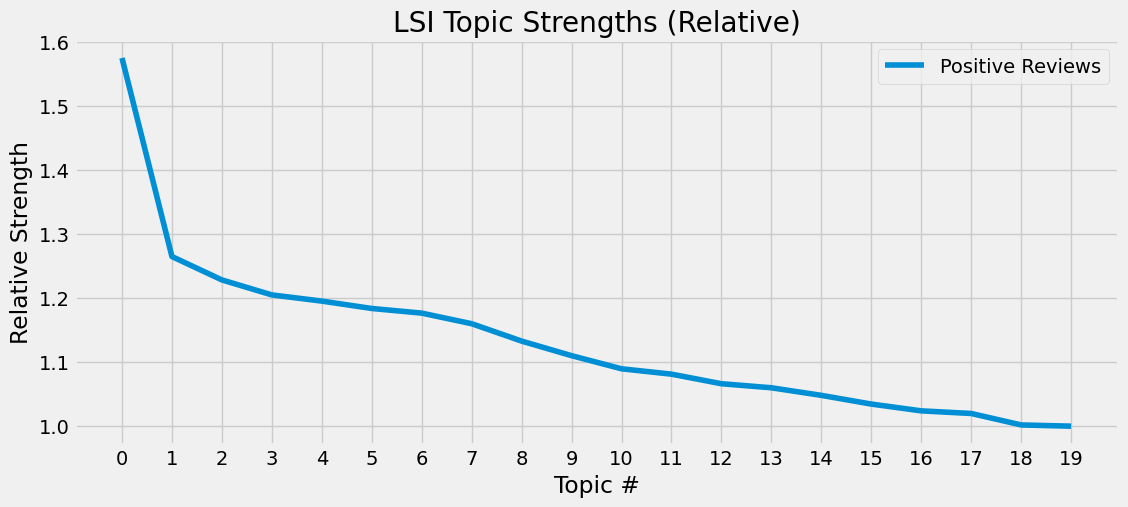

In [75]:
# elbow plot
singular_values = lsi_pos.projection.s.tolist()
singular_values_rel = [sv/singular_values[-1] for sv in singular_values]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values)), singular_values_rel, label='Positive Reviews', alpha=1.0)
plt.xticks(range(len(singular_values)), range(len(singular_values)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

LSI Topics

In [76]:
# look at top positive topics
print('Top %d topics for Low reviews' %(5))
print('-'*33)
for i in range(5):
    print("Topic",i, " :" ,lsi2.show_topics()[i], "\n")

for i in range(5):
    print("Topic",i, " :" ,lsi_pos.show_topics()[i], "\n")

Top 5 topics for Low reviews
---------------------------------
Topic 0  : (0, '0.268*"one" + 0.265*"time" + 0.212*"ordered" + 0.195*"minutes" + 0.139*"server" + 0.136*"told" + 0.118*"waitress" + 0.116*"first" + 0.115*"chicken" + 0.111*"another"') 

Topic 1  : (1, '-0.451*"chicken" + 0.381*"minutes" + -0.229*"ordered" + 0.197*"time" + -0.155*"sauce" + 0.141*"wait" + -0.124*"meat" + -0.122*"rice" + 0.118*"told" + 0.118*"server"') 

Topic 2  : (2, '0.795*"pizza" + -0.203*"server" + 0.163*"time" + -0.159*"chicken" + 0.154*"location" + -0.129*"waitress" + -0.109*"drinks" + 0.107*"customer" + 0.094*"called" + -0.090*"minutes"') 

Topic 3  : (3, '0.537*"one" + -0.401*"minutes" + -0.368*"chicken" + -0.363*"ordered" + -0.199*"pizza" + 0.124*"people" + 0.117*"staff" + -0.085*"waitress" + -0.079*"took" + -0.076*"server"') 

Topic 4  : (4, '0.775*"time" + -0.256*"pizza" + -0.231*"one" + -0.198*"ordered" + 0.175*"chicken" + -0.136*"server" + 0.115*"first" + -0.114*"told" + 0.103*"location" + -0.102

Create Bigrams for the under and over 3 reviews

In [80]:
testLowStops = list(underThree['cleanTokens'])
# newstopwords = stopwords + ["like", "back", "good", "get", "even"]
testLow2 = []
for i in testLowStops:
    testLow2.append(create_ngramsList([word for word in i if word not in stopwords], 2))


In [81]:
testHighStops = list(overThree['cleanTokens'])
# newstopwords = stopwords + ["like", "back", "good", "get", "even"]
testHigh2 = []
for i in testHighStops:
    testHigh2.append(create_ngramsList([word for word in i if word not in stopwords],2))


In [83]:
testLow2[0]

['wheelchair access',
 'access giant',
 'giant renovation',
 'renovation somehow',
 'somehow managed',
 'managed requirement',
 'requirement install',
 'install ramp',
 'ramp wheelchair',
 'wheelchair accessible',
 'accessible washrooms',
 'washrooms try',
 'try coffee',
 'coffee house',
 'house better',
 'better wheelchair']

In [78]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df_bow', 1233605120),
 ('albertaClean', 219806695),
 ('alberta', 173844220),
 ('overThree', 65691245),
 ('underThree', 24112271),
 ('id2word2', 20971608),
 ('finalDf', 3512917),
 ('businessReview', 2807749),
 ('businessReviewCopy', 1308165),
 ('businessStars', 857142),
 ('reviewList', 749936),
 ('cleanTextSeperate', 578928),
 ('cleanTokensSeperate', 578928),
 ('finalList2', 578928),
 ('buildClean', 551112),
 ('checkList', 551112),
 ('reviewSeperate', 551112),
 ('buildCleanHigh', 200312),
 ('highTokens', 182824),
 ('buildCleanLow', 61424),
 ('lowTokens', 60744),
 ('avgRat', 21040),
 ('cleanText', 21040),
 ('cleanTokens', 21040),
 ('finalList', 21040),
 ('newList', 21040),
 ('allReviewsList', 19336),
 ('checkList2', 19336),
 ('tok', 19336),
 ('TfidfVectorizer', 2008),
 ('tempStop', 1936),
 ('stopwords', 1736),
 ('CountVectorizer', 1472),
 ('Counter', 1064),
 ('review', 688),
 ('j', 632),
 ('rev2List', 632),
 ('expanded_words', 520),
 ('revFinal', 520),
 ('str1', 463),
 ('noPunc', 371)

In [246]:
print(stopwords.__contains__("not"))

True


LDA topic modelling

In [874]:
from gensim.corpora import Dictionary

dictionary = Dictionary(testLow2)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)
corpus = [dictionary.doc2bow(review) for review in testLow2]

In [43]:
dictionaryhigh = Dictionary(testHigh2)
dictionaryhigh.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)
corpushigh = [dictionaryhigh.doc2bow(review) for review in testHigh2]

In [884]:
from gensim.models import LdaModel
from pprint import pprint

model = LdaModel(corpus=corpus, id2word=dictionary, random_state=1, iterations=400, num_topics=3)
top_topics = list(model.top_topics(corpus))

In [45]:
modelHigh = LdaModel(corpus=corpushigh, id2word=dictionaryhigh, random_state=1, iterations=400, num_topics=5)
top_topicshigh = list(modelHigh.top_topics(corpushigh))

In [885]:
from gensim.models.coherencemodel import CoherenceModel

# Calculate the coherence score
coherence_model = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = coherence_model.get_coherence()
print("The coherence score is:", coherence)

The coherence score is: -8.408113354762284


Low rated topics

In [46]:
for idx in range(3):
    print("Topic #%s:\n" % idx, model.print_topic(idx, 10))
    print("\n")
print("=" * 20)

Topic #0:
 0.007*"one star" + 0.006*"skip dishes" + 0.006*"waited minutes" + 0.006*"every time" + 0.006*"deep fried" + 0.006*"last time" + 0.006*"behind counter" + 0.005*"needless say" + 0.005*"walked away" + 0.005*"drive thru"


Topic #1:
 0.008*"first time" + 0.007*"last night" + 0.006*"waste money" + 0.005*"stay away" + 0.005*"save money" + 0.005*"next time" + 0.005*"bad experience" + 0.005*"looking forward" + 0.004*"tim hortons" + 0.004*"took minutes"


Topic #2:
 0.015*"first time" + 0.012*"minutes later" + 0.008*"long time" + 0.007*"another minutes" + 0.007*"last time" + 0.005*"second time" + 0.005*"much better" + 0.005*"every time" + 0.004*"prime rib" + 0.004*"took minutes"




High rated topics

In [47]:
for idx in range(5):
    print("Topic #%s:\n" % idx, modelHigh.print_topic(idx, 10))
    print("\n")
print("=" * 20)

Topic #0:
 0.009*"every time" + 0.007*"one best" + 0.007*"first time" + 0.005*"bubble tea" + 0.004*"fish chips" + 0.004*"next time" + 0.003*"staff friendly" + 0.003*"one favourite" + 0.003*"friendly staff" + 0.003*"always fresh"


Topic #1:
 0.006*"cactus club" + 0.005*"first time" + 0.004*"pulled pork" + 0.003*"little bit" + 0.003*"friendly staff" + 0.003*"st albert" + 0.003*"super friendly" + 0.003*"fresh delicious" + 0.003*"reasonably priced" + 0.003*"dining experience"


Topic #2:
 0.005*"gluten free" + 0.004*"make sure" + 0.004*"ice cream" + 0.004*"deep fried" + 0.003*"super friendly" + 0.003*"fried chicken" + 0.003*"staff friendly" + 0.003*"next day" + 0.003*"n cheese" + 0.003*"mac n"


Topic #3:
 0.005*"love love" + 0.004*"always friendly" + 0.004*"first time" + 0.004*"sherwood park" + 0.004*"staff always" + 0.003*"top notch" + 0.003*"next time" + 0.003*"pleasantly surprised" + 0.003*"always fresh" + 0.003*"dim sum"


Topic #4:
 0.007*"spring rolls" + 0.007*"butter chicken" + 0.

Show topic visulizations

In [ ]:
# !pip install pyLDAvis

In [48]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=model.id2word)
vis

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.069737  0.132147       1        1  36.118251
0     -0.086271 -0.123129       2        1  32.859671
1      0.156009 -0.009018       3        1  31.022078, topic_info=                 Term        Freq       Total Category  logprob  loglift
62      minutes later  242.000000  242.000000  Default  30.0000  30.0000
242       skip dishes  101.000000  101.000000  Default  29.0000  29.0000
1515        prime rib   65.000000   65.000000  Default  28.0000  28.0000
89          stay away   80.000000   80.000000  Default  27.0000  27.0000
294     chicken wings   58.000000   58.000000  Default  26.0000  26.0000
...               ...         ...         ...      ...      ...      ...
410       much better   46.141919  129.727480   Topic3  -5.6218   0.1368
306          let know   41.166657  109.586885   Topic3  -5.7359   0.1914
198   another minutes   44.260840  194.780724   Topic3  -5.6634  -0.3113
345       decided try   37.436508   71.935003   Topic3  -5.8309   0.5174
177           sub par   37.202480   75.262231   Topic3  -5.8371   0.4659

[243 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
338       1  0.091080  absolutely terrible
338       3  0.910799  absolutely terrible
1810      3  0.975654         almost empty
638       3  0.932831         almost hours
1293      1  0.973012         also noticed
...     ...       ...                  ...
1172      1  0.982506             year ago
528       1  0.701523             year old
528       2  0.125914             year old
528       3  0.161890             year old
1559      1  0.970829         yelp account

[410 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [49]:
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim.prepare(modelHigh, corpushigh, dictionary=modelHigh.id2word)
vis2

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.041601  0.114808       1        1  20.546663
4     -0.174747 -0.214797       2        1  20.227769
3     -0.110298  0.179766       3        1  20.047220
1      0.172790 -0.034702       4        1  19.760714
2      0.153857 -0.045074       5        1  19.417633, topic_info=                   Term        Freq       Total Category  logprob  loglift
3128     butter chicken  411.000000  411.000000  Default  30.0000  30.0000
9080        cactus club  367.000000  367.000000  Default  29.0000  29.0000
4032          love love  245.000000  245.000000  Default  28.0000  28.0000
1930       spring rolls  454.000000  454.000000  Default  27.0000  27.0000
901         green onion  213.000000  213.000000  Default  26.0000  26.0000
...                 ...         ...         ...      ...      ...      ...
2086          take home   90.376230  224.657863   Topic5  -6.2321   0.7284
411   dining experience   86.331565  262.357286   Topic5  -6.2779   0.5275
435          every time  110.208058  747.503453   Topic5  -6.0337  -0.2754
606    great atmosphere   89.593667  329.681702   Topic5  -6.2408   0.3361
4123         happy hour   79.770252  269.604525   Topic5  -6.3569   0.4212

[354 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
474       1  0.086783  absolutely delicious
474       2  0.207660  absolutely delicious
474       3  0.210759  absolutely delicious
474       4  0.340934  absolutely delicious
474       5  0.154970  absolutely delicious
...     ...       ...                   ...
3345      1  0.918666             yam fries
3345      2  0.023965             yam fries
3345      4  0.023965             yam fries
3345      5  0.031954             yam fries
3627      4  0.993410               yum yum

[708 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 2, 3])

NMF topic modelling (Used in final product)

In [184]:
%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 4

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(bow_rep_tfidf)
H_pos = nmf_pos.components_


CPU times: total: 5.95 s
Wall time: 5.68 s


In [999]:
%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 4

nmf_fiveStar = NMF(n_components=num_topics)
W_posfiveStar  = nmf_fiveStar.fit_transform(bow_rep_tfidfHigh)
H_posfiveStar  = nmf_fiveStar.components_


CPU times: total: 9.88 s
Wall time: 9.42 s


1 star topics and 5 star topics

In [185]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf2.get_feature_names(), 4, 20)




Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   0.338*waited minutes, 0.322*another minutes, 0.322*took minutes, 0.312*drive thru, 0.257*minutes later, 0.253*every time, 0.202*last time, 0.201*long time, 0.168*half hour, 0.138*waste time, 0.137*one star, 0.126*walked away, 0.124*last night, 0.119*somewhere else, 0.118*waited another, 0.117*waste money, 0.116*waited waited, 0.114*gluten free, 0.111*right away, 0.108*needless say
Topic 1:   0.449*fried rice, 0.370*spring rolls, 0.348*deep fried, 0.321*ginger beef, 0.282*sweet sour, 0.191*sour pork, 0.152*green onion, 0.129*onion cakes, 0.126*chow mein, 0.122*chicken balls, 0.115*chicken fried, 0.112*pad thai, 0.102*give stars, 0.089*fries deep, 0.089*made yelp, 0.087*effort review, 0.087*call come, 0.087*day long, 0.087*name patty, 0.087*apart cheese
Topic 2:   0.901*first time, 0.290*second time, 0.110*time ordered, 0.108*last time, 0.103*twice first, 0.083*better places, 0.079*well done, 0.079

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:   0.625*chicken, 0.507*delicious, 0.468*also, 0.458*time, 0.444*try, 0.426*menu
Topic 1:   2.064*pizza, 0.369*crust, 0.272*toppings, 0.235*donair, 0.225*pizzas, 0.224*best pizza
Topic 2:   1.738*great, 0.473*staff, 0.468*atmosphere, 0.384*friendly, 0.300*amazing, 0.299*great great
Topic 3:   1.349*always, 0.732*best, 0.702*love, 0.477*edmonton, 0.430*sushi, 0.349*friendly


In [1000]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_fiveStar, tfidf.get_feature_names(), 4, no_top_words)


Top topics + words for POSITIVE reviews
---------------------------------------


c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:   0.649*first time, 0.602*one best, 0.448*every time, 0.276*spring rolls, 0.270*one favourite, 0.259*fried chicken
Topic 1:   1.559*friendly staff, 0.384*super friendly, 0.165*staff definitely, 0.120*staff super, 0.092*atmosphere friendly, 0.083*staff delicious
Topic 2:   1.567*love love, 0.051*love absolutely, 0.049*love best, 0.040*awesome definitely, 0.035*die buffet, 0.035*days wait
Topic 3:   1.340*staff friendly, 0.309*friendly helpful, 0.118*amazing staff, 0.098*delicious staff, 0.092*friendly knowledgeable, 0.079*clean staff


In [397]:
# look at a random positive review
import numpy as np
review_num = np.random.randint(0, high=len(buildCleanLow))
print(review_num)
print(buildCleanLow[review_num])

2732
have been to this location a few times for the mixed fruit bubble tea it has been very good and it has made me return however today it was ordered and it was terrible girl who made it looked like she was in training and must have made it wrong tastes like watered down milk with no fruit flavour undrinkable total waste of money if i had not left the store and was not stuck stuck in traffic i would have taken it back it was so bad now will not return to this location as if they have someone new training they should be watching them and ensure their menu is made correctly


In [398]:
# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [889]:
# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(buildCleanLow[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000
service was awful food was almost inedible i had the roast beef sandwich and the gravy had no flavor the poutine was awful for the same reason the garlic shrimp was dry and gross our server disappeared for about minutes with out anyone picking up the slack i will never go back
--------------------------------------------------
>> Similarity 1.000
after a very disappointing series of interactions with this business i will not be back after booking two large events with this restaurant and losing a deposit i will warn all others to make sure that they obtain a written contract when booking a large event here i had booked two large events one on july th and one on august nd i was asked for a deposit which i figured was acceptable given that we would need almost the entire restaurant what happened next was unexpected and unfortunate i attempted to notify the owner on monday july st that our first event would be much sma

Example of topic distribution for a single review

In [400]:
# we can investigate a random positive review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(buildCleanLow))
print('Negatvie Review #%d' %review_num)
print('-'*25)
print(buildCleanLow[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negatvie Review #2607
-------------------------
i took my son and daughter out for an th birthday grade grad dinner for my son we spent over on the bill with drinks appetizers and dessert both my son and i ended up with diarrhea shortly after i left a message with the restaurant they called back days later and said they would discuss this with the chef before getting back to me as they take these type of things seriously i never heard back even after leaving another message i expect much better service from a high end restaurant i live in the neighbourhood and will never return customer service is everything and this restaurant does not service its customers
-------------------------
Topic 0: 0.0089
Topic 1: 0.0022
Topic 2: 0.0000
Topic 3: 0.0000


Label topics based on words

In [1094]:

# create topic dictionaries to summarize the topic meanings
low_rating_topics = {0:'drive thru/wait time', 1:'chinese food', 2:'first time/bad experience', 
              3:'hygiene'}

In [1095]:
high_rating_topics = {0:'Number of Visits / Food', 1:'Service / Atmosphere', 2:'Very Postive Time', 
              3:'Staff / Food'}

# high_rating_topics = {0:'delicious/chicken', 1:'pizza', 2:'staff/atmosphere', 
#               3:'best/favourite'}

Create dataframes to pair topics back to resturants

In [206]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_test = underThree[['business_id', 'name', 'review_stars', 'text']][underThree.review_stars<2].reset_index()
df_test.drop(labels='index', axis=1, inplace=True)

print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())



Topic weights :  [0.00056393 0.         0.         0.00028401]
Sum of weights:  0.0008479415242853056


In [1003]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_testHigh = overThree[['business_id', 'name', 'review_stars', 'text']][overThree.review_stars>4].reset_index()
df_testHigh.drop(labels='index', axis=1, inplace=True)

print('Topic weights : ', W_posfiveStar[0])
print('Sum of weights: ', W_posfiveStar[0].sum())


Topic weights :  [0.01296888 0.         0.00029524 0.        ]
Sum of weights:  0.01326412444728723


Normalize the topic weights to present a percentage to resturants

In [208]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

df_test = pd.concat([df_test, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
# peek into a dataframe to ensure it worked right


Normalized Topic weights :  [[0.66505822 0.         0.         0.33494178]]
Sum of normalized weights:  1.0


In [1004]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_posfiveStar[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_posfiveStar[0].reshape(1,-1), norm='l1').sum())

df_testfiveStar = pd.concat([df_testHigh, pd.DataFrame(normalize(W_posfiveStar, norm='l1'))], axis=1)
# peek into a dataframe to ensure it worked right

Normalized Topic weights :  [[0.97774145 0.         0.02225855 0.        ]]
Sum of normalized weights:  1.0


df_test = 1 star review topics

df_testfiveStar = 5 star review topics

In [210]:
df_test.head()

,business_id,name,review_stars,text,0,1,2,3
0,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,1,No Wheelchair Access!\n\n- How is it that they...,0.665058,0.000000,0.000000,0.334942
1,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,1,"As several other reviewers have observed, this...",0.945474,0.000000,0.042862,0.011664
2,YR0nwxBOKk6DiLHNItfsBQ,Boston Pizza,1,Going out for heart shaped pizzas on Palentine...,0.999839,0.000000,0.000000,0.000161
3,YR0nwxBOKk6DiLHNItfsBQ,Boston Pizza,1,I'm really unhappy with the service I received...,1.000000,0.000000,0.000000,0.000000
4,jcL_qaGJiappzpnn-ifSoA,Fat Jakks,1,Just cleaning up some old reviews I haven't po...,0.734292,0.057521,0.208187,0.000000


In [1005]:
df_testfiveStar.head()

,business_id,name,review_stars,text,0,1,2,3
0,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,5,Hope everybody had a nice Valentine's Day yest...,0.977741,0.000000,0.022259,0.000000
1,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,5,"Delicious coffee, great service, wonderful atm...",0.738021,0.261979,0.000000,0.000000
2,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,5,A great trendy coffee house on my favourite st...,0.829494,0.000000,0.047634,0.122872
3,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,5,"By far, my favourite coffeehouse in the city! ...",0.172633,0.827367,0.000000,0.000000
4,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,5,I was surprised to hear that this place had cl...,0.734348,0.000000,0.265652,0.000000


Find average values of topic weights for each resturant

In [212]:
# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_test.groupby('business_id').agg({'name': 'first', 'review_stars':'mean', 'text':'count',
                                                 0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean'}).reset_index()


In [1006]:
# group by business_id and apply mean/count functions to columns
df_pos_fiveStar = df_testfiveStar.groupby('business_id').agg({'name': 'first', 'review_stars':'mean', 'text':'count',
                                                 0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean'}).reset_index()


In [214]:
df_pos_bsns.sort_values(by='text',ascending=False)[0:20]

,business_id,name,review_stars,text,0,1,2,3
1631,swUT7AsP776D0XEBQrSznA,Bubba Gump Shrimp Co.,1.0,46,0.742224,0.092003,0.160566,0.005207
1611,sPxAZRMzMsvwO2e8impPBA,MKT,1.0,34,0.838787,0.042175,0.108503,0.010534
442,F0XiRcSbcLF4GwA2A2TDKQ,El Cortez Mexican Kitchen + Tequila Bar,1.0,34,0.741970,0.094865,0.129066,0.004688
949,WzxcOFfMnuABFrrC6zEncg,New York Bagel Cafe,1.0,29,0.808907,0.064517,0.123356,0.003219
668,N-ej51lLtIl4TMC-Qb3k4A,Zen All-You-Can-Eat Sushi & Grill,1.0,29,0.700464,0.149064,0.142509,0.007964
1352,jEvoDXtF3xMJsiPPbqGSmw,Tres Carnales Taqueria,1.0,28,0.771983,0.103519,0.109570,0.014929
1297,hC9FlobGGp0G2C59WzOfFg,The Rec Room,1.0,28,0.749260,0.089678,0.159290,0.001772
476,GW0b7o1wghFlQCoWv4zHgQ,Volcano Restaurant,1.0,26,0.463796,0.264658,0.262554,0.008991
1599,s3blBsUKQQKW1QCGuo040w,Red Robin Gourmet Burgers and Brews,1.0,26,0.889749,0.032642,0.067244,0.010365
1652,tt4lgEAXQcS_Cdy8cbb3rw,Blue Plate Diner,1.0,24,0.670631,0.183930,0.139959,0.005480


In [1007]:
df_pos_fiveStar.sort_values(by='text',ascending=False)[20:50]

,business_id,name,review_stars,text,0,1,2,3
128,2fTfpN5SggLgW4LlzptMPg,Tzin Wine & Tapas,5.0,76,0.834589,0.042993,0.033555,0.088863
1198,ZUPnWlLgqnU1PVtF6Q9-HQ,Lan's Asian Grill,5.0,75,0.820104,0.076495,0.037550,0.065851
2002,w8IHN58WRQ7-9euvBSkr0w,Dorinku Tokyo,5.0,75,0.845890,0.044090,0.038698,0.057989
1814,qQ5uuXrKu-Japb9rT2sx0Q,Guru,5.0,75,0.874539,0.049964,0.030403,0.045094
81,1LVMlrAQeqLgiwFu06kFfw,The Workshop Eatery,5.0,74,0.856895,0.028304,0.022860,0.091940
212,56p80CBDCpnS2t9cU9nZNQ,Northern Chicken,5.0,74,0.884407,0.044662,0.018934,0.051998
539,FvkSgBooMT5kfgXbU4FE9w,Jack's Burger Shack,5.0,73,0.713029,0.126617,0.030562,0.129792
1581,ivpULDSBS4mP3mJqmziKQw,Cafe Amore Bistro,5.0,73,0.789980,0.103098,0.017244,0.089678
950,S6HhMZgDpAdpArUKRlrSrw,Japonais Bistro,5.0,70,0.868949,0.036155,0.036883,0.058012
1112,XCHMsIpz2htBIvE7dxXL0g,The Marc,5.0,70,0.814882,0.049895,0.037626,0.097598


Analyze one resturant

In [403]:

scores = df_pos_bsns[df_pos_bsns.business_id == '9PCU1jKEaysLfaETpYEHxg'].iloc[:,-4:].values
print(df_pos_bsns[df_pos_bsns.business_id == '9PCU1jKEaysLfaETpYEHxg']['name'].values[0] + ' - 1 Star Reviews')
print('-'*36)
for n in low_rating_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, low_rating_topics[n], scores[0][n]))

Blaze Pizza - 1 Star Reviews
------------------------------------
Topic 0: drive thru/wait_time > 0.5893
Topic 1: chinaese food      > 0.0431
Topic 2: first_time/bad_experience > 0.3676
Topic 3: hygiene            > 0.0000


In [1118]:
df_testfiveStar[df_testfiveStar['business_id'] == "PVDh-6ge94GefpNfXzsSGw"][['text',0,1,2,3]].loc[19031]

text    We've already been her twice this month. It's ...
0                                                0.260802
1                                                     0.0
2                                                     0.0
3                                                0.739198
Name: 19031, dtype: object

In [1096]:

scores1 = df_pos_fiveStar[df_pos_fiveStar.business_id == 'PVDh-6ge94GefpNfXzsSGw'].iloc[:,-4:].values
print(df_pos_fiveStar[df_pos_fiveStar.business_id == 'PVDh-6ge94GefpNfXzsSGw']['name'].values[0] + ' - 5 Star Reviews')
print('-'*36)
for n in high_rating_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, high_rating_topics[n], scores1[0][n]))

LovePizza - 5 Star Reviews
------------------------------------
Topic 0: Number of Visits / Food > 0.6975
Topic 1: Service / Atmosphere > 0.0435
Topic 2: Very Postive Time  > 0.1316
Topic 3: Staff / Food       > 0.1274


In [ ]:
scores2 = df_pos_bsns[df_pos_bsns.business_id == 'PVDh-6ge94GefpNfXzsSGw'].iloc[:,-4:].values
print(df_pos_bsns[df_pos_bsns.business_id == 'PVDh-6ge94GefpNfXzsSGw']['name'].values[0] + ' - 5 Star Reviews')
print('-'*36)
for n in low_rating_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, low_rating_topics[n], scores2[0][n]))

Analyze LovePizzas review to show example resturant and how these visulizations could be used

In [1116]:
scores2 = df_pos_bsns[df_pos_bsns.business_id == 'PVDh-6ge94GefpNfXzsSGw'].iloc[:,-4:].values
print(df_pos_bsns[df_pos_bsns.business_id == 'PVDh-6ge94GefpNfXzsSGw']['name'].values[0] + ' - 5 Star Reviews')
print('-'*36)
for n in low_rating_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, low_rating_topics[n], scores2[0][n]))

LovePizza - 5 Star Reviews
------------------------------------
Topic 0: drive thru/wait time > 0.6771
Topic 1: chinese food       > 0.1031
Topic 2: first time/bad experience > 0.1730
Topic 3: hygiene            > 0.0468


In [1062]:
scores = []
topics = []
for i in range(4):
    topics.append(low_rating_topics[i])
    scores.append(scores1[0][i])
for i in range(4):
    topics.append(high_rating_topics[i])
    scores.append(scores2[0][i])

In [81]:
topics = ['Drive thru/wait_time',
 'Chinese food',
 'First_time/bad_experience',
 'Hygiene',
 'Number of Visits / Food Items',
 'Service / Atmosphere',
 'Extremely Positive Experience',
 'Staff / Food']

In [79]:
posNeg = [1,1,1,1,5,5,5,5]

In [85]:
pizzaRest = pd.DataFrame()
pizzaRest['Topics'] = topics
pizzaRest['Weight'] = scores
pizzaRest['Star'] = posNeg

In [1053]:
topics

['drive thru/wait_time',
 'chinaese food',
 'first_time/bad_experience',
 'hygiene',
 'Number of Visits / Food Items',
 'Service / Atmosphere',
 'Extremaly Postive Expierie',
 'Staff / Food']

LovePizza's 1 star and 5 star topic distributions

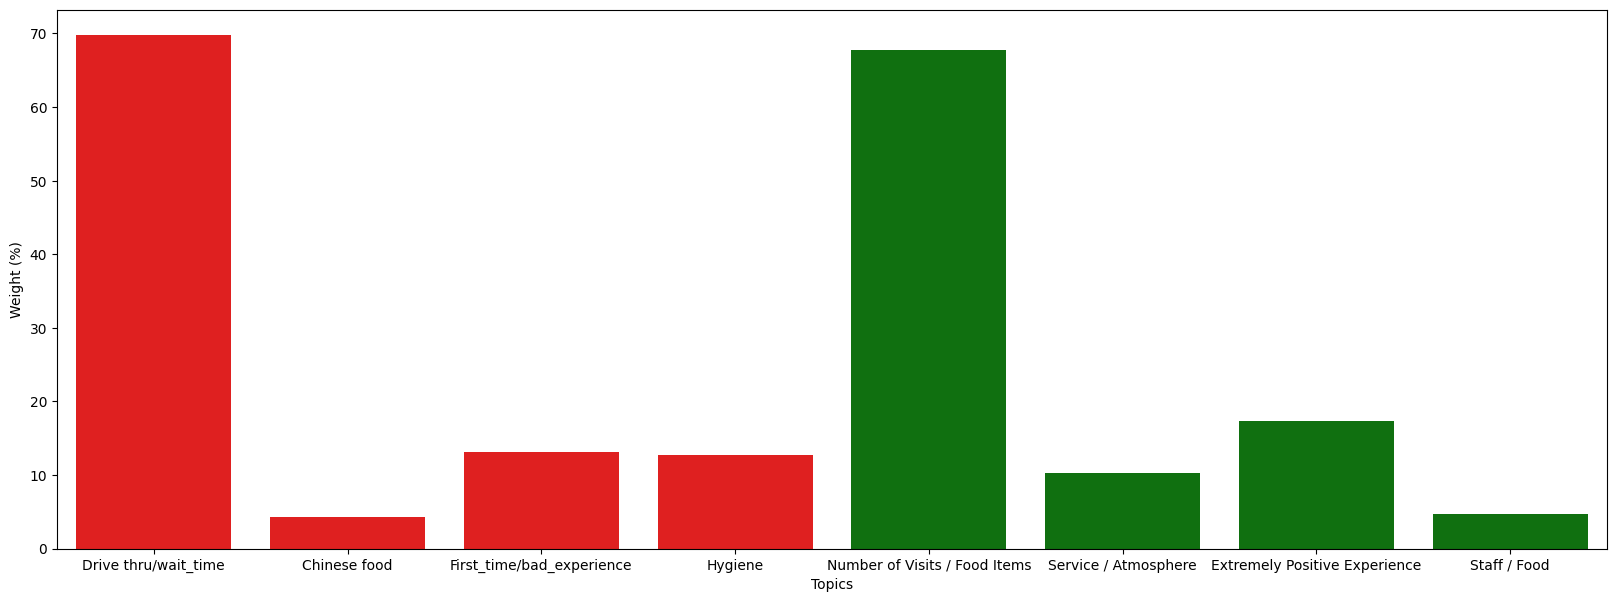

In [92]:
import seaborn as sns
cols = ['red' if x == 1 else 'green' for x in pizzaRest.Star]
plt.figure(figsize=(20,7))

sns.barplot(data=pizzaRest, x='Topics', y='Weight', palette=cols)
plt.ylabel("Weight (%)")
plt.show()

In [1102]:
df_test[df_test['business_id'] == "PVDh-6ge94GefpNfXzsSGw"][['text',0,1,2,3]].loc[6841].text

,text,0,1,2,3
6431,Terrible treatment today- I am a bypass patie...,0.757874,0.000000,0.000000,0.242126
6432,Most disgusting pizza I have EVER had. \nI cou...,0.362264,0.327698,0.237401,0.072637
6433,I asked to sub an ingredient on my pizza and t...,0.504688,0.000000,0.495312,0.000000
6434,After my visit today at the Love Pizza I canno...,0.901231,0.000000,0.098769,0.000000
6435,This pizza is very bland. It's definitely tren...,1.000000,0.000000,0.000000,0.000000
6837,I found the pizza here pretty average. I'm no...,0.866854,0.000000,0.000000,0.133146
6838,"Ordered two pizzas, one was the original style...",0.469452,0.252842,0.277706,0.000000
6839,"Worst Pizza & Unapologetic, Bad Service.\n\nI ...",0.553946,0.225369,0.197452,0.023233
6840,I went to order delivery. I input my address a...,0.321899,0.328587,0.349514,0.000000
6841,Ordering online looked like it would be easy e...,0.996795,0.000000,0.000000,0.003205


In [1121]:
reviewDist = df_test[df_test['business_id'] == "PVDh-6ge94GefpNfXzsSGw"][['text',0,1,2,3]].loc[6841]
print(reviewDist['text'])
for n in low_rating_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, low_rating_topics[n], reviewDist[n]))

print("\n")
reviewDist = df_testfiveStar[df_testfiveStar['business_id'] == "PVDh-6ge94GefpNfXzsSGw"][['text',0,1,2,3]].loc[19031]
print(reviewDist['text'])
for n in high_rating_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, high_rating_topics[n], reviewDist[n]))

Ordering online looked like it would be easy enough. Ordered 2 pizzas yesterday and online said 60 minutes for delivery. 60 minutes passes and I get a message that the driver will be there in 2 minutes. I go down to the front door to greet the driver and NO driver. I called LovePizza and they tell me that the driver was at my place for 15 minutes. I called BS on that statement. They then had the audacity to tell me the driver will return in 25 minutes. They also claimed they couldn't call me on the cell number I was calling them on. They had my email and cell phone number as confirmed on the phone call. Place is run by lying morons. I won't bother with them again with the amount of better run establishments in Edmonton.
Topic 0: drive thru/wait time > 0.9968
Topic 1: chinese food       > 0.0000
Topic 2: first time/bad experience > 0.0000
Topic 3: hygiene            > 0.0032


We've already been her twice this month. It's pretty quick, reasonably priced, the staff are friendly, and the 

Review Length visualizations

In [139]:
albertaClean.groupby(by="review_stars").count()

,business_id,name,address,stars,is_open,review_count,attributes,categories,text,date,cleanTokens
review_stars,,,,,,,,,,,
1,7586,7586,7577,7586,7586,7586,7517,7586,7586,7586,7586
2,6653,6653,6642,6653,6653,6653,6625,6653,6653,6653,6653
3,10420,10420,10408,10420,10420,10420,10383,10420,10420,10420,10420
4,21377,21377,21352,21377,21377,21377,21267,21377,21377,21377,21377
5,22846,22846,22820,22846,22846,22846,22691,22846,22846,22846,22846


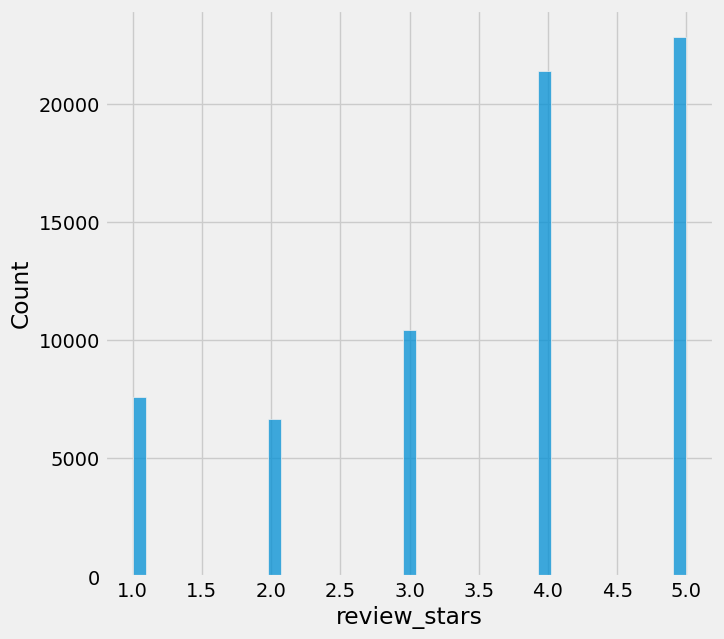

In [140]:
import seaborn as sns
plt.figure(figsize=(7,7))
sns.histplot(data=albertaClean, x="review_stars");

Find the main category of a resturant

In [85]:
test2 = list(finalDf['categories'])

In [86]:
mainCat = []
for i in test2:
    cat = i.split(",")
    mainCat.append(cat[0])


In [87]:
uniqueCats = (list(set(mainCat)))

In [88]:
uniqueCats

['Cafes',
 'Brazilian',
 'Indonesian',
 'Arcades',
 'Ukrainian',
 'Italian',
 'Pakistani',
 'Steakhouses',
 'Barbeque',
 'Breakfast & Brunch',
 'Food Delivery Services',
 'Fondue',
 'Event Planning & Services',
 'Whiskey Bars',
 'Poutineries',
 'Lebanese',
 'Street Vendors',
 'Cantonese',
 'Seafood',
 'Fish & Chips',
 'Religious Organizations',
 'Buffets',
 'Gyms',
 'Food',
 'Sushi Bars',
 'Laotian',
 'Canadian (New)',
 'Ramen',
 'Caterers',
 'Sandwiches',
 'Turkish',
 'International',
 'Greek',
 'Taiwanese',
 'German',
 'Lounges',
 'Coffee & Tea',
 'Desserts',
 'Food Stands',
 'Chicken Wings',
 'Donairs',
 'Mediterranean',
 'Recreation Centers',
 'Creperies',
 'Tapas Bars',
 'Beer',
 'Diners',
 'Organic Stores',
 'Cocktail Bars',
 'Hawaiian',
 'American (Traditional)',
 'Pubs',
 'Japanese',
 'Health Markets',
 'Tacos',
 'French',
 'Chinese',
 'African',
 'Poke',
 'Delicatessen',
 'Food Court',
 'Local Flavor',
 'Salvadoran',
 'Sri Lankan',
 'Bistros',
 'Noodles',
 'Imported Food',
 'H

In [89]:
finalDf['mainCategory'] = mainCat

In [90]:
finalDf.groupby(by="mainCategory").count().sort_values(by="name", ascending=False)[2:10]

,business_id,name,text,review_count,categories,rawData,cleanedTokens,review_stars,avgRating
mainCategory,,,,,,,,,
Pizza,85,85,85,85,85,85,85,85,85
Fast Food,78,78,78,78,78,78,78,78,78
Chinese,74,74,74,74,74,74,74,74,74
Burgers,64,64,64,64,64,64,64,64,64
Italian,60,60,60,60,60,60,60,60,60
Nightlife,58,58,58,58,58,58,58,58,58
Canadian (New),51,51,51,51,51,51,51,51,51
Vietnamese,49,49,49,49,49,49,49,49,49


Scatter Text


Resources used for ScatterText Code:


- https://github.com/gyhou/yelp_dataset/blob/master/notebooks/yelp_RV_nlp_scattertext.ipynb
- https://github.com/JasonKessler/scattertext#understanding-scaled-f-score
- https://spacy.io/universe/project/scattertext




In [ ]:
# !pip install scattertext

In [219]:
import scattertext

Check cleaning

In [220]:
count = 0
for i in list(albertaClean['cleanTokens']):
    for j in i:
        for k in j:
            if(k.isalpha() == False):
                print(k)
                count+=1
print(count)

0


In [221]:
cleanTextJoined = list(albertaClean['cleanTokens'])

In [222]:
joinedText = []
for busRev in cleanTextJoined:
    newList = " ".join([word for word in busRev])
    joinedText.append(newList)

In [223]:
albertaClean['cleanText'] = joinedText

C:\Users\User\AppData\Local\Temp\ipykernel_1504\2716272615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['cleanText'] = joinedText


In [225]:
test3 = list(albertaClean['categories'])

mainCat2 = []
for i in test3:
    cat = i.split(",")
    mainCat2.append(cat[0])

uniqueCats2 = (list(set(mainCat2)))
albertaClean['mainCategory'] = mainCat2

C:\Users\User\AppData\Local\Temp\ipykernel_1504\282829225.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['mainCategory'] = mainCat2


In [343]:
albertaClean.groupby(by="mainCategory").count().sort_values(by="name", ascending=False)[2:30]

,business_id,name,address,stars,is_open,review_count,attributes,categories,review_stars,text,date,cleanTokens,cleanText,rating
mainCategory,,,,,,,,,,,,,,
Nightlife,2646,2646,2646,2646,2646,2646,2640,2646,2646,2646,2646,2646,2646,2646
Italian,2207,2207,2207,2207,2207,2207,2196,2207,2207,2207,2207,2207,2207,2207
Canadian (New),2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037
Chinese,1655,1655,1655,1655,1655,1655,1641,1655,1655,1655,1655,1655,1655,1655
Breakfast & Brunch,1553,1553,1553,1553,1553,1553,1541,1553,1553,1553,1553,1553,1553,1553
Bars,1552,1552,1552,1552,1552,1552,1552,1552,1552,1552,1552,1552,1552,1552
Japanese,1448,1448,1448,1448,1448,1448,1448,1448,1448,1448,1448,1448,1448,1448
Pizza,1363,1363,1363,1363,1363,1363,1341,1363,1363,1363,1363,1363,1363,1363
Burgers,1351,1351,1351,1351,1351,1351,1340,1351,1351,1351,1351,1351,1351,1351


Look at Chinese and Pizza resturants

In [380]:
pizzaRevs = albertaClean[albertaClean['mainCategory'] == "Pizza"]
chinaRevs = albertaClean[albertaClean['mainCategory'] == "Chinese"]

In [370]:
chinaRevs

,business_id,name,address,stars,is_open,review_count,attributes,categories,review_stars,text,date,cleanTokens,cleanText,mainCategory,rating
76,jcL_qaGJiappzpnn-ifSoA,Fat Jakks,10126 - 107 Avenue NW,4.0,0,8,"{'RestaurantsDelivery': 'True', 'RestaurantsPr...","Chinese, Restaurants, Filipino",5,Very tasty Filipino cuisine. I very much enjoy...,2016-05-08 00:54:16,"[very, tasty, filipino, cuisine, i, very, much...",very tasty filipino cuisine i very much enjoye...,Chinese,High Rating
77,jcL_qaGJiappzpnn-ifSoA,Fat Jakks,10126 - 107 Avenue NW,4.0,0,8,"{'RestaurantsDelivery': 'True', 'RestaurantsPr...","Chinese, Restaurants, Filipino",5,Best Pinoy restaurant in Edmonton!\nNice staff...,2016-12-21 04:41:32,"[best, pinoy, restaurant, in, edmonton, nice, ...",best pinoy restaurant in edmonton nice staffgo...,Chinese,High Rating
78,jcL_qaGJiappzpnn-ifSoA,Fat Jakks,10126 - 107 Avenue NW,4.0,0,8,"{'RestaurantsDelivery': 'True', 'RestaurantsPr...","Chinese, Restaurants, Filipino",4,i have been maybe 3 or 4 times now. they have ...,2012-06-11 01:25:05,"[i, have, been, maybe, or, times, now, they, h...",i have been maybe or times now they have good ...,Chinese,4
79,jcL_qaGJiappzpnn-ifSoA,Fat Jakks,10126 - 107 Avenue NW,4.0,0,8,"{'RestaurantsDelivery': 'True', 'RestaurantsPr...","Chinese, Restaurants, Filipino",5,"we love the food, great value for your money, ...",2013-08-13 05:19:01,"[we, love, the, food, great, value, for, your,...",we love the food great value for your money as...,Chinese,High Rating
80,jcL_qaGJiappzpnn-ifSoA,Fat Jakks,10126 - 107 Avenue NW,4.0,0,8,"{'RestaurantsDelivery': 'True', 'RestaurantsPr...","Chinese, Restaurants, Filipino",3,The good\n\nDecor was vibrant and felt welcomi...,2018-08-31 19:58:23,"[the, good, decor, was, vibrant, and, felt, we...",the good decor was vibrant and felt welcoming ...,Chinese,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68552,wcHUOAXE60mlGxVcXjEfTQ,Wok Box,10119 Jasper Avenue NW,3.0,1,28,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Chinese, Fast Food, Restaurants",4,Tried this place yesterday - and I would have ...,2018-05-17 13:46:10,"[tried, this, place, yesterday, and, i, would,...",tried this place yesterday and i would have gi...,Chinese,4
68553,wcHUOAXE60mlGxVcXjEfTQ,Wok Box,10119 Jasper Avenue NW,3.0,1,28,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Chinese, Fast Food, Restaurants",5,So full!! Ordered the chicken Thai salad. It's...,2020-02-11 20:35:02,"[so, full, ordered, the, chicken, thai, salad,...",so full ordered the chicken thai salad its so ...,Chinese,High Rating
68554,wcHUOAXE60mlGxVcXjEfTQ,Wok Box,10119 Jasper Avenue NW,3.0,1,28,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Chinese, Fast Food, Restaurants",2,Ordered Wok Box from Skip the Dishes a couple ...,2019-04-15 03:27:45,"[ordered, wok, box, from, skip, the, dishes, a...",ordered wok box from skip the dishes a couple ...,Chinese,2
68555,wcHUOAXE60mlGxVcXjEfTQ,Wok Box,10119 Jasper Avenue NW,3.0,1,28,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Chinese, Fast Food, Restaurants",4,I'm a flight attendant and always eat at that ...,2013-02-21 18:43:42,"[i, am, a, flight, attendant, and, always, eat...",i am a flight attendant and always eat at that...,Chinese,4


In [371]:
# iceCreamYogurt = albertaClean[albertaClean['mainCategory'] == "Ice Cream & Frozen Yogurt"]
chinaRevs = chinaRevs[chinaRevs['rating'] == 'High Rating'].append(chinaRevs[chinaRevs['rating'] == 'Low Rating'])

C:\Users\User\AppData\Local\Temp\ipykernel_1504\1139776347.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chinaRevs = chinaRevs[chinaRevs['rating'] == 'High Rating'].append(chinaRevs[chinaRevs['rating'] == 'Low Rating'])


In [898]:
chinaRevs.rating.value_counts()

High Rating    1023
Low Rating      632
Name: rating, dtype: int64

In [901]:
pizzaRevs.review_stars.value_counts()

5    476
4    396
1    209
3    169
2    113
Name: review_stars, dtype: int64

Give stars a class of low or high

In [379]:
# Consolidate rating to high or low
albertaClean['rating'] = albertaClean['review_stars'].replace({1:'Low Rating', 2:'Low Rating', 3:'Low Rating',
                                           4:'High Rating', 5:'High Rating'})
albertaClean.rating.value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_1504\6107141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['rating'] = albertaClean['review_stars'].replace({1:'Low Rating', 2:'Low Rating', 3:'Low Rating',


High Rating    44223
Low Rating     24659
Name: rating, dtype: int64

In [230]:
stops = nlp.Defaults.stop_words

In [238]:
from nltk.corpus import stopwords


  
stop_words = list(set(stopwords.words('english')))

In [239]:
stops = list(stops) + stop_words

In [241]:
stops = list(set(stops))
len(stops)

382

In [244]:
from scattertext import SampleCorpora, PhraseMachinePhrases, dense_rank, RankDifference, AssociationCompactor, produce_scattertext_explorer


Create term frequency dataframes for each bigram

In [381]:
def term_freq(df_yelp):
    corpus = (scattertext.CorpusFromPandas(df_yelp,
                                           category_col='rating', 
                                           text_col='cleanText',
                                           feats_from_spacy_doc=PhraseMachinePhrases(),
                                           nlp=nlp)
              .build()
              .remove_terms(stops, ignore_absences=True).compact(AssociationCompactor(4000))
              # ignore_absences: if the term does not appear, don't raise an error, just move on.
              )
    
    df = corpus.get_term_freq_df()
    df['High_Rating_Score'] = corpus.get_scaled_f_scores('High Rating')
    df['Low_Rating_Score'] = corpus.get_scaled_f_scores('Low Rating')

    df['High_Rating_Score'] = round(df['High_Rating_Score'], 2)
    df['Low_Rating_Score'] = round(df['Low_Rating_Score'], 2)
    
    df_high = df.sort_values(by='High Rating freq', 
                             ascending = False).reset_index()
    df_low = df.sort_values(by='Low Rating freq', 
                            ascending=False).reset_index()
    
    return df_high, df_low

In [382]:
testing_high, testing_low = term_freq(pizzaRevs)

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\scattertext\termscoring\ScaledFScore.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.zeros(len(cat_scores)).astype(np.float)
c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\scattertext\termscoring\ScaledFScore.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

In [383]:
testing_high

,term,Low Rating freq,High Rating freq,High_Rating_Score,Low_Rating_Score
0,best pizza,4,51,0.98,0.02
1,thin crust,13,45,0.92,0.08
2,first time,18,41,0.15,0.85
3,pizza place,19,40,0.14,0.86
4,customer service,37,32,0.06,0.94
...,...,...,...,...,...
1791,last couple,4,0,0.11,0.89
1792,hour for delivery,2,0,0.32,0.68
1793,bare hands,5,0,0.05,0.95
1794,year old kid,2,0,0.32,0.68


In [524]:
# # testing_high['totalTerm'] = testing_high['Low Rating freq'] + testing_high['High Rating freq']
# testing_high[testing_high['totalTerm'] > 50]

,term,Low Rating freq,High Rating freq,High_Rating_Score,Low_Rating_Score,totalTerm
0,pizza,804,1418,0.89,0.11,2222
1,great,115,437,0.95,0.05,552
2,i have,177,367,0.91,0.09,544
3,and the,137,314,0.91,0.09,451
4,it was,236,284,0.13,0.87,520
...,...,...,...,...,...,...
1077,not even,45,15,0.04,0.96,60
1166,would not,48,14,0.03,0.97,62
1216,ok,59,13,0.02,0.98,72
1486,i asked,41,11,0.03,0.97,52


Create the corpus to put into the ScatterText function

In [ ]:
corpus = (scattertext.CorpusFromPandas(pizzaRevs,
                                           category_col='rating', 
                                           text_col='cleanText',
                                           feats_from_spacy_doc=scattertext.FlexibleNGrams(
                                            ngram_sizes=[3]
                                        ),
                                           
                                           nlp=nlp)
              .build()
              .remove_terms(stops, ignore_absences=True)
              # ignore_absences: if the term does not appear, don't raise an error, just move on.
              ).compact(AssociationCompactor(4000))

In [393]:
corpus = (scattertext.CorpusFromPandas(pizzaRevs,
                                           category_col='rating', 
                                           text_col='cleanText',
                                           feats_from_spacy_doc=PhraseMachinePhrases(),
                                           nlp=nlp)
              .build()
              .remove_terms(stops, ignore_absences=True)
              # ignore_absences: if the term does not appear, don't raise an error, just move on.
              ).compact(AssociationCompactor(4000))

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\scattertext\termscoring\ScaledFScore.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.zeros(len(cat_scores)).astype(np.float)
c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\scattertext\termscoring\ScaledFScore.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

In [491]:
unigrams = list(testing_high['term'].append(testing_low['term']))

C:\Users\User\AppData\Local\Temp\ipykernel_19668\2905901695.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unigrams = list(testing_high['term'].append(testing_low['term']))


In [492]:
unigrams = list(set(unigrams))

In [493]:
len(unigrams)

67541

In [494]:
unigramsFiltered = []
for i in unigrams:
    uni = False
    for j in i:
        if(j == ' '):
            # print(i)
            uni = True
            break
    if(uni == False):
        unigramsFiltered.append(i)

In [495]:
len(unigramsFiltered)

7365

In [497]:
corpus = corpus.remove_terms(unigramsFiltered, ignore_absences=True)

Pizza ScatterText

In [394]:
# Label each excerpt with the name of business using the metadata parameter
corpus_dataframe = pizzaRevs
# html = scattertext.produce_scattertext_explorer(corpus,
#                                                 category='Low Rating',
#                                                 category_name='Low Rating',
#                                                 not_category_name='High Rating',
#                                                 width_in_pixels=1000,
#                                                 # minimum_term_frequency=50,
#                                                 metadata=corpus_dataframe[['name', 'review_stars']])


html = produce_scattertext_explorer(corpus,
                                    category='Low Rating',
                                    category_name='Low Rating',
                                    not_category_name='High Rating',
                                    # minimum_term_frequency=0,
                                    pmi_threshold_coefficient=0,
                                    # transform=dense_rank,
                                    metadata=corpus.get_df()['name'],
                                    # term_scorer=RankDifference(),
                                    width_in_pixels=1000)

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\scattertext\termscoring\ScaledFScore.py:303: RuntimeWarning: invalid value encountered in divide
  recall = cat_word_counts * 1. / cat_word_counts.sum()


Create HTML file

In [396]:
html_file_name = "Edmonton-Yelp-Review-PizzaPhrases-ScattertextCopy.html"
open(html_file_name, 'wb').write(html.encode('utf-8'))

1245720

Chinese resturant ScatterText

In [373]:
corpus = (scattertext.CorpusFromPandas(chinaRevs,
                                           category_col='rating', 
                                           text_col='cleanText',
                                           nlp=nlp)
              .build()
              .remove_terms(stops, ignore_absences=True))

In [374]:
corpus = corpus.add_doc_names_as_metadata(corpus.get_df()['name'])

Looking to place reviews into space as opposed to bigrams using ScatterText (Results not included in final product)

In [375]:

from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse.linalg import svds

In [376]:
embeddings = TfidfTransformer().fit_transform(corpus.get_term_doc_mat())
u, s, vt = svds(embeddings, k=3, maxiter=20000, which='LM')
projection = pd.DataFrame({'term': corpus.get_metadata(), 'x': u.T[0], 'y': u.T[1]}).set_index('term')

In [377]:

scores = (corpus.get_category_ids() == corpus.get_categories().index('Low Rating')).astype(int)
html = scattertext.produce_pca_explorer(corpus,
                               category='Low Rating',
                               category_name='Low Rating',
                               not_category_name='High Rating',
                               metadata=chinaRevs[['name', 'review_stars']],
                               width_in_pixels=1000,
                               show_axes=True,
                               use_non_text_features=True,
                               use_full_doc=True,
                               projection=projection,
                               scores=scores,
                               show_top_terms=False)

In [378]:
html_file_name = "Edmonton-Yelp-Review-Scattertext-chineaseFood.html"
open(html_file_name, 'wb').write(html.encode('utf-8'))

958112

In [ ]:

corpus = (scattertext.CorpusFromPandas(pizzaRevs,
                                        category_col='rating', 
                                        text_col='cleanText',
                                        nlp=nlp)
            .build()
            .remove_terms(stops, ignore_absences=True).remove_terms(unigramsFiltered, ignore_absences=True)
            # ignore_absences: if the term does not appear, don't raise an error, just move on.
            )

df = corpus.get_term_freq_df()
df['High_Rating_Score'] = corpus.get_scaled_f_scores('High Rating')
df['Low_Rating_Score'] = corpus.get_scaled_f_scores('Low Rating')

df['High_Rating_Score'] = round(df['High_Rating_Score'], 2)
df['Low_Rating_Score'] = round(df['Low_Rating_Score'], 2)

df_high = df.sort_values(by='High Rating freq', 
                            ascending = False).reset_index()
df_low = df.sort_values(by='Low Rating freq', 
                        ascending=False).reset_index()
    
df_high, df_low

In [570]:
df_high['total'] = df_high['Low Rating freq'] + df_high['High Rating freq']
# df_high

In [574]:
df_high[df_high['total'] > 50]

,term,Low Rating freq,High Rating freq,High_Rating_Score,Low_Rating_Score,total
0,i have,177,367,0.90,0.10,544
1,and the,137,314,0.91,0.09,451
2,it was,236,284,0.13,0.87,520
3,in the,166,253,0.87,0.13,419
4,of the,154,251,0.88,0.12,405
...,...,...,...,...,...,...
366,if i,44,22,0.06,0.94,66
454,my order,46,19,0.05,0.95,65
588,not even,45,15,0.04,0.96,60
634,would not,48,14,0.03,0.97,62


In [575]:
# Label each excerpt with the name of business using the metadata parameter
corpus_dataframe = pizzaRevs
# html = scattertext.produce_scattertext_explorer(corpus,
#                                                 category='Low Rating',
#                                                 category_name='Low Rating',
#                                                 not_category_name='High Rating',
#                                                 width_in_pixels=1000,
#                                                 # minimum_term_frequency=50,
#                                                 metadata=corpus_dataframe[['name', 'review_stars']])


html = produce_scattertext_explorer(corpus,
                                    category='Low Rating',
                                    category_name='Low Rating',
                                    not_category_name='High Rating',
                                    minimum_term_frequency=50,
                                    pmi_threshold_coefficient=0,
                                    # transform=dense_rank,
                                    metadata=corpus.get_df()['name'],
                                    # term_scorer=RankDifference(),
                                    width_in_pixels=1000)

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\scattertext\termscoring\ScaledFScore.py:303: RuntimeWarning: invalid value encountered in divide
  recall = cat_word_counts * 1. / cat_word_counts.sum()


In [576]:
html_file_name = "Edmonton-Yelp-Review-Scattertext.html"
open(html_file_name, 'wb').write(html.encode('utf-8'))

1246491

In [ ]:
create_ngramsList(corpus, 2)

Word2Vec Model from scratch

In [91]:
# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Create list of birgrams

In [25]:
from gensim.models import Word2Vec

# define training data
corpus = list(albertaClean['cleanTokens'])
biVecs = []
for i in corpus:
    biList = create_ngramsList([word for word in i if word not in stopwords], 2)
    biVecs.append(biList)

#Training the model
# model_cbow = Word2Vec(corpus, vector_size=100, window=3, min_count=1, sg=0)

Three models. 

1. Stopwords removed
2. Stopwords left in
3. Pretrained google news model

In [451]:
model_bigrmas = Word2Vec(biVecs, vector_size=100, window=3, min_count=1, sg=0)

In [26]:
model_bigramsNoStop = Word2Vec(biVecs, vector_size=300, window=3, min_count=1, sg=0)

import gensim.downloader

gensim.downloader.info('word2vec-google-news-300')
w2v_model = gensim.downloader.load('word2vec-google-news-300')

In [462]:
w2v_vocabulary = model_bigrmas.wv

In [32]:
import numpy as np

Experiment with t-SNE plot using word2vec model

In [ ]:
def display_closestwords_tsnescatterplot(model, words, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [words[0]]
    close_words = model.wv.most_similar(words[0],  topn=30)
    
    arr2 = np.empty((0,size), dtype='f')
    word_labels2 = [words[1]]
    close_words2 = model.wv.most_similar(words[1],  topn=30)
    
    arr = np.append(arr, np.array([model.wv[words[0]]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    arr= np.append(arr, np.array([model.wv[words[1]]]), axis=0)
    for wrd_score in close_words2:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
    
    tsne = TSNE(n_components=2, random_state=0,perplexity=30)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
display_closestwords_tsnescatterplot(model_bigramsNoStop, ['drive thru', 'bad food'], 100) 

Function to make features for the models

In [53]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0
    index2word_set = set(model.wv.index_to_key)  # words known to the model
    # index2word_set = set(model.index_to_key)  # words known to the model
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            feature_vec = np.add(feature_vec,model.wv[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(reviews, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    j = 0
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for review in reviews:
        review_feature_vecs[j] = make_feature_vec(review, model, num_features)
        j = j + 1
    return review_feature_vecs

Create my samples from the star ratings (6000 each)

In [35]:
sampleSet1 = albertaClean[albertaClean['review_stars'] == 1].sample(n=6000)
sampleSet2 = albertaClean[albertaClean['review_stars'] == 2].sample(n=6000)
sampleSet4 = albertaClean[albertaClean['review_stars'] == 4].sample(n=6000)
sampleSet5 = albertaClean[albertaClean['review_stars'] == 5].sample(n=6000)


# sampleSet = sampleSet1.append(sampleSet2).append(sampleSet4).append(sampleSet5)
sampleSet  = sampleSet1.append(sampleSet5)
sampleSet24 = sampleSet2.append(sampleSet4)

C:\Users\User\AppData\Local\Temp\ipykernel_2072\1580047513.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampleSet  = sampleSet1.append(sampleSet5)
C:\Users\User\AppData\Local\Temp\ipykernel_2072\1580047513.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampleSet24 = sampleSet2.append(sampleSet4)


In [38]:
x_train, x_test, y_train, y_test = train_test_split(sampleSet['cleanTokens'], sampleSet['review_stars'], random_state=1, stratify=sampleSet['review_stars'])

In [1207]:
x_train, x_test, y_train, y_test = train_test_split(sampleSet24['cleanTokens'], sampleSet24['review_stars'], random_state=1, stratify=sampleSet24['review_stars'])

Remove stopwords from training and test data

In [1169]:
x_noStop = []
for i in x_train:
    noStop = [word for word in i if word not in stopwords]
    x_noStop.append(noStop)

In [1170]:
xTest_noStop = []
for i in x_test:
    noStop =  [word for word in i if word not in stopwords]
    xTest_noStop.append(noStop)

In [40]:
x_bi = []
for i in x_train:
    biX = create_ngramsList([word for word in i if word not in stopwords], 2)
    x_bi.append(biX)

In [41]:
xTest_bi = []
for i in x_test:
    biX = create_ngramsList([word for word in i if word not in stopwords], 2)
    xTest_bi.append(biX)

In [954]:
y_train.value_counts('review_stars')

1    0.5
5    0.5
Name: review_stars, dtype: float64

In [46]:
len(x_bi)

9000

Create training feature vectors for my model and pretrained

In [ ]:
# trainRevs = list(x_train['cleanTokens'])
trainRevs = x_bi

trainDataVecs = get_avg_feature_vecs(trainRevs, model_bigramsNoStop, 100)

In [1214]:
# trainRevs = list(x_train['cleanTokens'])
trainRevs = x_train

trainDataVecs = get_avg_feature_vecs(trainRevs,w2v_model, 300)

C:\Users\User\AppData\Local\Temp\ipykernel_1504\1065274514.py:14: RuntimeWarning: invalid value encountered in divide
  feature_vec = np.divide(feature_vec, nwords)


Create test feature vectors for my model and from scratch

In [1215]:
# testRevs = list(albertaClean['cleanTokens'])[3000:3300]
testRevs = x_test
testDataVecs = get_avg_feature_vecs(testRevs, w2v_model, 300)

In [56]:
# testRevs = list(albertaClean['cleanTokens'])[3000:3300]
testRevs = xTest_bi
testDataVecs = get_avg_feature_vecs(testRevs, model_bigramsNoStop, 300)

Check for nan values

In [70]:
vecDf = pd.DataFrame(testDataVecs)
yes = pd.DataFrame(y_train)

In [71]:
print(vecDf.isnull().values.any())
yes.isnull().values.any()

False


False

In [72]:
y_test.value_counts()

1    1500
5    1500
Name: review_stars, dtype: int64

In [73]:
for i in range(300):
    nan_rows = vecDf[vecDf[i].isnull()]
    print(nan_rows)
    # print(i)

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18

In [63]:
zeros = np.zeros(300)



Set nan values to all zeros

In [64]:
trainDataVecs[1374  ] = zeros
trainDataVecs[2357    ] = zeros


Run classifiers

In [74]:
forest = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
# forest = forest.fit(trainDataVecs, list(albertaClean['review_stars'])[0:1000])
forest = forest.fit(trainDataVecs, y_train)

Fitting a random forest to labeled training data...


In [75]:
print("Predicting labels for test data..")
result = forest.predict(testDataVecs)
print(classification_report(y_test, result))

Predicting labels for test data..
              precision    recall  f1-score   support

           1       0.67      0.74      0.70      1500
           5       0.71      0.64      0.67      1500

    accuracy                           0.69      3000
   macro avg       0.69      0.69      0.69      3000
weighted avg       0.69      0.69      0.69      3000



In [109]:
finalDf[['mainCategory', 'business_id']]

,mainCategory,business_id
0,Breakfast & Brunch,--7PUidqRWpRSpXebiyxTg
1,Ukrainian,-2oyyfOSHs1UElr3Dc1aKQ
2,Restaurants,-3GD07waps96fB_okEwFqw
3,Pizza,-4lNMmoW7gRxkH0c2dfXfA
4,Ethnic Food,-4qgeqxb2hKe3dUUH__j8Q
...,...,...
2405,Burgers,zpXKeyg8GD2Z27Biaeqo8A
2406,Pubs,zun3rAOoiAyeIL3JIB4eYg
2407,Indian,zx7XemDyT296vmKnFtZSyQ
2408,Fast Food,zxJfzu6Hy4E5bjP9fzh93g


In [122]:
restBus = finalDf[['mainCategory', 'business_id']].merge(underThree, on="business_id")

In [131]:
restBus.value_counts('mainCategory')

mainCategory
Restaurants        2310
Food                335
Nightlife           263
Burgers             236
Fast Food           225
                   ... 
Organic Stores        1
Ethiopian             1
Meat Shops            1
Grocery               1
Hotels & Travel       1
Length: 137, dtype: int64